# Notebook Mission

The intented use of this notebook is to provide a space where the user can run all of the initial clustering model efforts with the set piece sequence data. The goal of this modeling effort is to arrive at a set of clustering predictions that can differentiate between different set piece strategies that teams employ throughout matches. The decision of which strategy to use can be dependent on game situation (i.e., score, time, etc...), player personel, and league characteristics, opposition, and coaching philosophy to name a few possible factors. The final goal is to arrive a set of explanation for what each cluster is characterized by to inspire future exploration.

# Neccessary Import Statements

In [1]:
# Allows for changes made to scripts in src to be included in the work
# done in this notebook.
%load_ext autoreload
%autoreload 2

In [2]:
# file access
import os
import joblib
notebook_dir = os.getcwd()

In [3]:
# data manipulation and calculation
import pandas as pd
import numpy as np
import swifter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

# ML-related packages
from sklearn.model_selection import train_test_split

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

# custom modules 
from src.data import common_tasks as ct
from src.data import feature_engineering as fe
from src.data import data_loader as dl
from src.models import clustering as clus
from src.visualizations import cluster_bar_chart_prep as cbcp
from src.visualizations import basic_viz as bv
from src.visualizations import pitch_plotting as pp

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Add a Score Column to the Raw Tracking Data

In [4]:
no_scores_full_df = ct.EVENTS_DF

In [5]:
no_scores_full_df.tail()

eventId           subEventName  \
3251289        5  Ball out of the field   
3251290        3                 Corner   
3251291        1               Air duel   
3251292        1               Air duel   
3251293       10                   Shot   

                                                      tags  playerId  \
3251289                                                 []         0   
3251290           [{'id': 302}, {'id': 801}, {'id': 1801}]     70965   
3251291                        [{'id': 701}, {'id': 1802}]      7919   
3251292                        [{'id': 703}, {'id': 1801}]      8005   
3251293  [{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...      8005   

                                          positions  matchId     eventName  \
3251289   [{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]  2500098  Interruption   
3251290  [{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]  2500098     Free Kick   
3251291    [{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]  2500098          Duel   
3251292    [{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]  2500098          Duel   
3251293      [{'y': 50, 'x': 86}, {'y': 0, 'x': 0}]  2500098          Shot   

         teamId matchPeriod     eventSec subEventId         id  
3251289    1623          2H  2796.732525         50  251596409  
3251290    1633          2H  2829.821084         30  251596232  
3251291    1623          2H  2831.211419         10  251596410  
3251292    1633          2H  2832.434399         10  251596234  
3251293    1633          2H  2834.127168        100  251596236

### Following Code Actually Gets Column. Only Run If Data Is Not Already Saved

In [6]:
full_df = ct.score_compiler()

In [7]:
full_df.tail()

matchId  eventId           subEventName  \
3251289  1694414        8            Simple pass   
3251290  1694414        1  Ground defending duel   
3251291  1694414        1  Ground attacking duel   
3251292  1694414        8            Simple pass   
3251293  1694414        8                 Launch   

                                                      tags  playerId  \
3251289                                     [{'id': 1801}]      8744   
3251290  [{'id': 503}, {'id': 1601}, {'id': 703}, {'id'...     51132   
3251291           [{'id': 504}, {'id': 701}, {'id': 1802}]      8240   
3251292                                     [{'id': 1801}]     51132   
3251293                                     [{'id': 1802}]      8192   

                                         positions eventName  teamId  \
3251289   [{'y': 80, 'x': 62}, {'y': 94, 'x': 81}]      Pass    8274   
3251290     [{'y': 6, 'x': 19}, {'y': 11, 'x': 2}]      Duel    7047   
3251291   [{'y': 94, 'x': 81}, {'y': 89, 'x': 98}]      Duel    8274   
3251292     [{'y': 11, 'x': 2}, {'y': 18, 'x': 5}]      Pass    7047   
3251293  [{'y': 18, 'x': 5}, {'y': 100, 'x': 100}]      Pass    7047   

        matchPeriod     eventSec subEventId        id score  
3251289          2H  2866.900643         85  88351785   1-1  
3251290          2H  2869.166034         12  88351656   1-1  
3251291          2H  2870.644437         11  88351786   1-1  
3251292          2H  2872.588773         85  88351658   1-1  
3251293          2H  2873.749723         84  88351659   1-1

In [8]:
full_df[full_df.matchId == 2500097]

matchId  eventId           subEventName                         tags  \
3057788  2500097        8            Simple pass               [{'id': 1801}]   
3057789  2500097        8              High pass               [{'id': 1801}]   
3057790  2500097        1               Air duel  [{'id': 702}, {'id': 1801}]   
3057791  2500097        1               Air duel  [{'id': 702}, {'id': 1801}]   
3057792  2500097        8              High pass               [{'id': 1802}]   
...          ...      ...                    ...                          ...   
3059291  2500097        1  Ground defending duel  [{'id': 702}, {'id': 1801}]   
3059292  2500097        1  Ground attacking duel  [{'id': 702}, {'id': 1801}]   
3059293  2500097        5  Ball out of the field                           []   
3059294  2500097        3               Throw in               [{'id': 1801}]   
3059295  2500097        7                  Touch                           []   

         playerId                                   positions  \
3057788     25804    [{'y': 50, 'x': 50}, {'y': 59, 'x': 32}]   
3057789        36    [{'y': 59, 'x': 32}, {'y': 24, 'x': 70}]   
3057790      3928    [{'y': 76, 'x': 30}, {'y': 95, 'x': 23}]   
3057791      8717     [{'y': 24, 'x': 70}, {'y': 5, 'x': 77}]   
3057792    149019    [{'y': 95, 'x': 23}, {'y': 49, 'x': 71}]   
...           ...                                         ...   
3059291    419784     [{'y': 94, 'x': 7}, {'y': 100, 'x': 9}]   
3059292     13484      [{'y': 6, 'x': 93}, {'y': 0, 'x': 91}]   
3059293         0  [{'y': 100, 'x': 8}, {'y': 100, 'x': 100}]   
3059294      8292      [{'y': 0, 'x': 91}, {'y': 5, 'x': 65}]   
3059295    210044       [{'y': 5, 'x': 65}, {'y': 0, 'x': 0}]   

                  eventName  teamId matchPeriod     eventSec subEventId  \
3057788                Pass    1624          1H     1.601308         85   
3057789                Pass    1624          1H     4.275583         83   
3057790                Duel    1631          1H     7.284606         10   
3057791                Duel    1624          1H     7.520837         10   
3057792                Pass    1631          1H    12.189233         83   
...                     ...     ...         ...          ...        ...   
3059291                Duel    1631          2H  3055.590071         12   
3059292                Duel    1624          2H  3056.333973         11   
3059293        Interruption    1631          2H  3061.998929         50   
3059294           Free Kick    1624          2H  3071.680085         36   
3059295  Others on the ball    1624          2H  3072.634675         72   

                id score  
3057788  251620174   0-0  
3057789  251620175   0-0  
3057790  251620067   0-0  
3057791  251620177   0-0  
3057792  251620068   0-0  
...            ...   ...  
3059291  251621842   4-5  
3059292  251621795   4-5  
3059293  251621843   4-5  
3059294  251621797   4-5  
3059295  251621799   4-5  

[1508 rows x 13 columns]

In [9]:
### ONLY RUN CELL IF YOU WOULD LIKE TO SAVE THIS DATAFRAME ### 
score_rel_dir = "../data/interim"
score_dir = os.path.join(notebook_dir, score_rel_dir)

full_df.to_csv("{}/events_with_scores.csv".format(score_dir))

### Only run following cells if the new dataframe with the score column has been saved

In [10]:
### ONLY RUN CELL IF YOU LIKE TO LOAD IN THIS DATAFRAME ###
score_rel_dir = "../data/interim"
score_dir = os.path.join(notebook_dir, score_rel_dir)

full_df = pd.read_csv(
    "{}/events_with_scores.csv".format(score_dir)
).drop(columns=["Unnamed: 0"])

In [11]:
full_df.tail()

matchId  eventId           subEventName  \
3251289  1694414        8            Simple pass   
3251290  1694414        1  Ground defending duel   
3251291  1694414        1  Ground attacking duel   
3251292  1694414        8            Simple pass   
3251293  1694414        8                 Launch   

                                                      tags  playerId  \
3251289                                     [{'id': 1801}]      8744   
3251290  [{'id': 503}, {'id': 1601}, {'id': 703}, {'id'...     51132   
3251291           [{'id': 504}, {'id': 701}, {'id': 1802}]      8240   
3251292                                     [{'id': 1801}]     51132   
3251293                                     [{'id': 1802}]      8192   

                                         positions eventName  teamId  \
3251289   [{'y': 80, 'x': 62}, {'y': 94, 'x': 81}]      Pass    8274   
3251290     [{'y': 6, 'x': 19}, {'y': 11, 'x': 2}]      Duel    7047   
3251291   [{'y': 94, 'x': 81}, {'y': 89, 'x': 98}]      Duel    8274   
3251292     [{'y': 11, 'x': 2}, {'y': 18, 'x': 5}]      Pass    7047   
3251293  [{'y': 18, 'x': 5}, {'y': 100, 'x': 100}]      Pass    7047   

        matchPeriod     eventSec  subEventId        id score  
3251289          2H  2866.900643        85.0  88351785   1-1  
3251290          2H  2869.166034        12.0  88351656   1-1  
3251291          2H  2870.644437        11.0  88351786   1-1  
3251292          2H  2872.588773        85.0  88351658   1-1  
3251293          2H  2873.749723        84.0  88351659   1-1

In [12]:
full_df[full_df.matchId == 2500097]

matchId  eventId           subEventName                         tags  \
3057788  2500097        8            Simple pass               [{'id': 1801}]   
3057789  2500097        8              High pass               [{'id': 1801}]   
3057790  2500097        1               Air duel  [{'id': 702}, {'id': 1801}]   
3057791  2500097        1               Air duel  [{'id': 702}, {'id': 1801}]   
3057792  2500097        8              High pass               [{'id': 1802}]   
...          ...      ...                    ...                          ...   
3059291  2500097        1  Ground defending duel  [{'id': 702}, {'id': 1801}]   
3059292  2500097        1  Ground attacking duel  [{'id': 702}, {'id': 1801}]   
3059293  2500097        5  Ball out of the field                           []   
3059294  2500097        3               Throw in               [{'id': 1801}]   
3059295  2500097        7                  Touch                           []   

         playerId                                   positions  \
3057788     25804    [{'y': 50, 'x': 50}, {'y': 59, 'x': 32}]   
3057789        36    [{'y': 59, 'x': 32}, {'y': 24, 'x': 70}]   
3057790      3928    [{'y': 76, 'x': 30}, {'y': 95, 'x': 23}]   
3057791      8717     [{'y': 24, 'x': 70}, {'y': 5, 'x': 77}]   
3057792    149019    [{'y': 95, 'x': 23}, {'y': 49, 'x': 71}]   
...           ...                                         ...   
3059291    419784     [{'y': 94, 'x': 7}, {'y': 100, 'x': 9}]   
3059292     13484      [{'y': 6, 'x': 93}, {'y': 0, 'x': 91}]   
3059293         0  [{'y': 100, 'x': 8}, {'y': 100, 'x': 100}]   
3059294      8292      [{'y': 0, 'x': 91}, {'y': 5, 'x': 65}]   
3059295    210044       [{'y': 5, 'x': 65}, {'y': 0, 'x': 0}]   

                  eventName  teamId matchPeriod     eventSec  subEventId  \
3057788                Pass    1624          1H     1.601308        85.0   
3057789                Pass    1624          1H     4.275583        83.0   
3057790                Duel    1631          1H     7.284606        10.0   
3057791                Duel    1624          1H     7.520837        10.0   
3057792                Pass    1631          1H    12.189233        83.0   
...                     ...     ...         ...          ...         ...   
3059291                Duel    1631          2H  3055.590071        12.0   
3059292                Duel    1624          2H  3056.333973        11.0   
3059293        Interruption    1631          2H  3061.998929        50.0   
3059294           Free Kick    1624          2H  3071.680085        36.0   
3059295  Others on the ball    1624          2H  3072.634675        72.0   

                id score  
3057788  251620174   0-0  
3057789  251620175   0-0  
3057790  251620067   0-0  
3057791  251620177   0-0  
3057792  251620068   0-0  
...            ...   ...  
3059291  251621842   4-5  
3059292  251621795   4-5  
3059293  251621843   4-5  
3059294  251621797   4-5  
3059295  251621799   4-5  

[1508 rows x 13 columns]

# Join With Sequence Data

### First, load in that sequence data and wrangle it (only run if data is NOT saved)

In [13]:
sequences_df = dl.sequence_data(with_scores=False)
sequences_df

eventId           subEventName  \
0              3              Free Kick   
1              8            Simple pass   
2              8            Simple pass   
3              8            Simple pass   
4              8            Simple pass   
...          ...                    ...   
1891129        8                  Cross   
1891130        7              Clearance   
1891131        5  Ball out of the field   
1891132        3                 Corner   
1891133        7              Clearance   

                                             tags  playerId  \
0                                  [{'id': 1801}]         0   
1                                  [{'id': 1801}]     50007   
2                                  [{'id': 1801}]     24838   
3                                  [{'id': 1801}]     21415   
4                                  [{'id': 1801}]    284960   
...                                           ...       ...   
1891129  [{'id': 402}, {'id': 801}, {'id': 1802}]    341973   
1891130              [{'id': 1401}, {'id': 1802}]     28529   
1891131                                        []         0   
1891132               [{'id': 801}, {'id': 1802}]    244335   
1891133              [{'id': 1401}, {'id': 1802}]    410062   

                                        positions  matchId  \
0        [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040   
1        [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040   
2        [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040   
3        [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040   
4        [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040   
...                                           ...      ...   
1891129  [{'y': 72, 'x': 96}, {'y': 38, 'x': 96}]  2501010   
1891130    [{'y': 62, 'x': 4}, {'y': 64, 'x': 0}]  2501010   
1891131   [{'y': 36, 'x': 100}, {'y': 0, 'x': 0}]  2501010   
1891132  [{'y': 0, 'x': 100}, {'y': 45, 'x': 89}]  2501010   
1891133  [{'y': 55, 'x': 11}, {'y': 64, 'x': 26}]  2501010   

                  eventName  teamId matchPeriod     eventSec subEventId  \
0                 Free Kick    3219          2H  2216.339790         31   
1                      Pass    3219          2H  2221.716912         85   
2                      Pass    3219          2H  2225.150837         85   
3                      Pass    3219          2H  2228.885593         85   
4                      Pass    3219          2H  2231.951066         85   
...                     ...     ...         ...          ...        ...   
1891129                Pass    3787          2H  1662.199741         80   
1891130  Others on the ball    3772          2H  1664.021805         71   
1891131        Interruption    3787          2H  1670.963763         50   
1891132           Free Kick    3787          2H  1685.122411         30   
1891133  Others on the ball    3772          2H  1686.592945         71   

                id  seq_id  
0        198792553     100  
1        198792554     100  
2        198792555     100  
3        198792556     100  
4        198792557     100  
...            ...     ...  
1891129  243183546  275429  
1891130  243183126  275429  
1891131  243183547  275429  
1891132  243183548  275430  
1891133  243183127  275430  

[1891134 rows x 13 columns]

In [28]:
sequences_df.sort_values(by=["matchId", "matchPeriod", "eventSec"],
                         inplace=True)
sequences_df.reset_index(drop=True, inplace=True)

sequences_df

eventId            subEventName  \
0              3                Throw in   
1              8               Head pass   
2             10                    Shot   
3              9            Save attempt   
4              3                Throw in   
...          ...                     ...   
1891129        1  Ground loose ball duel   
1891130        1  Ground loose ball duel   
1891131        1  Ground loose ball duel   
1891132        1                Air duel   
1891133        1                Air duel   

                                                      tags  playerId  \
0                                           [{'id': 1802}]      7915   
1                             [{'id': 1401}, {'id': 1802}]     70090   
2        [{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...     25437   
3                             [{'id': 1203}, {'id': 1801}]     83574   
4                                           [{'id': 1802}]     70090   
...                                                    ...       ...   
1891129                        [{'id': 702}, {'id': 1801}]     14745   
1891130                        [{'id': 702}, {'id': 1801}]    413041   
1891131                        [{'id': 702}, {'id': 1801}]    413041   
1891132                        [{'id': 703}, {'id': 1801}]     20927   
1891133                        [{'id': 703}, {'id': 1801}]     20927   

                                           positions  matchId     eventName  \
0            [{'y': 0, 'x': 85}, {'y': 16, 'x': 93}]  1694390     Free Kick   
1             [{'y': 84, 'x': 7}, {'y': 71, 'x': 9}]  1694390          Pass   
2             [{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]  1694390          Shot   
3        [{'y': 100, 'x': 100}, {'y': 100, 'x': 15}]  1694390  Save attempt   
4          [{'y': 100, 'x': 47}, {'y': 84, 'x': 66}]  1694390     Free Kick   
...                                              ...      ...           ...   
1891129       [{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]  2576338          Duel   
1891130     [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338          Duel   
1891131     [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338          Duel   
1891132    [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338          Duel   
1891133    [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338          Duel   

         teamId matchPeriod     eventSec subEventId         id  seq_id  
0          4418          1H    27.053006         36   88178648  147152  
1         11944          1H    28.975160         82   88178667  147152  
2          4418          1H    31.226217        100   88178649  147152  
3         11944          1H    32.664160         91   88178674  147152  
4         11944          1H    78.185236         36   88178702  158389  
...         ...         ...          ...        ...        ...     ...  
1891129    3185          2H  2872.101142         13  253567161  132550  
1891130    3193          2H  2872.990437         13  253567163   33514  
1891131    3193          2H  2872.990437         13  253567163  132550  
1891132    3185          2H  2874.049206         10  253567162   33514  
1891133    3185          2H  2874.049206         10  253567162  132550  

[1891134 rows x 13 columns]

Evidently, the assignment of a sequence ID (see `seq_id` column) did not go according to plan as we seperated the data into three different files. Thus, we will clean up that column here. We do this by taking advantage of the fact that each set piece sequence begins with a value for the `eventId` column of 3.

In [29]:
indicies_of_sequence_starts = np.argwhere(
    (sequences_df.eventId == 3).to_numpy()
).flatten()
indicies_of_sequence_starts

array([      0,       4,       9, ..., 1891115, 1891126, 1891127])

In [30]:
sp_sequence_ids_list = []
last_start = 0
current_id = 100
for index in indicies_of_sequence_starts:
    # First, update values for all of the events that make up the sequence
    # whose beginning row index we are now working with during this iteration.
    if last_start != index:
        sp_sequence_ids_list += [current_id]*(index-last_start)
    
        # Update necessary values
        current_id += 1
        last_start = index + 1
        
        sp_sequence_ids_list.append(current_id)
        assert len(sp_sequence_ids_list) == index + 1

# Fill in the values 
sp_sequence_ids_list += [current_id]*(
    sequences_df.shape[0]-len(sp_sequence_ids_list))

assert len(sp_sequence_ids_list) == sequences_df.shape[0]

In [31]:
sequences_df.drop(columns="seq_id", inplace=True) 
sequences_df["seq_id"] = pd.Series(sp_sequence_ids_list)
sequences_df

eventId            subEventName  \
0              3                Throw in   
1              8               Head pass   
2             10                    Shot   
3              9            Save attempt   
4              3                Throw in   
...          ...                     ...   
1891129        1  Ground loose ball duel   
1891130        1  Ground loose ball duel   
1891131        1  Ground loose ball duel   
1891132        1                Air duel   
1891133        1                Air duel   

                                                      tags  playerId  \
0                                           [{'id': 1802}]      7915   
1                             [{'id': 1401}, {'id': 1802}]     70090   
2        [{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...     25437   
3                             [{'id': 1203}, {'id': 1801}]     83574   
4                                           [{'id': 1802}]     70090   
...                                                    ...       ...   
1891129                        [{'id': 702}, {'id': 1801}]     14745   
1891130                        [{'id': 702}, {'id': 1801}]    413041   
1891131                        [{'id': 702}, {'id': 1801}]    413041   
1891132                        [{'id': 703}, {'id': 1801}]     20927   
1891133                        [{'id': 703}, {'id': 1801}]     20927   

                                           positions  matchId     eventName  \
0            [{'y': 0, 'x': 85}, {'y': 16, 'x': 93}]  1694390     Free Kick   
1             [{'y': 84, 'x': 7}, {'y': 71, 'x': 9}]  1694390          Pass   
2             [{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]  1694390          Shot   
3        [{'y': 100, 'x': 100}, {'y': 100, 'x': 15}]  1694390  Save attempt   
4          [{'y': 100, 'x': 47}, {'y': 84, 'x': 66}]  1694390     Free Kick   
...                                              ...      ...           ...   
1891129       [{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]  2576338          Duel   
1891130     [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338          Duel   
1891131     [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338          Duel   
1891132    [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338          Duel   
1891133    [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338          Duel   

         teamId matchPeriod     eventSec subEventId         id  seq_id  
0          4418          1H    27.053006         36   88178648     100  
1         11944          1H    28.975160         82   88178667     100  
2          4418          1H    31.226217        100   88178649     100  
3         11944          1H    32.664160         91   88178674     100  
4         11944          1H    78.185236         36   88178702     101  
...         ...         ...          ...        ...        ...     ...  
1891129    3185          2H  2872.101142         13  253567161  206237  
1891130    3193          2H  2872.990437         13  253567163  206237  
1891131    3193          2H  2872.990437         13  253567163  206237  
1891132    3185          2H  2874.049206         10  253567162  206237  
1891133    3185          2H  2874.049206         10  253567162  206237  

[1891134 rows x 13 columns]

### Now we are ready for the join to add the score column (only run if data is NOT saved)

In [32]:
# see https://stackoverflow.com/questions/40860457/improve-pandas-merge-performance
# for the trick used to speed up this join.
sequences_with_scores_df = sequences_df.set_index("id").merge(
    right=full_df[["score", "id"]].set_index("id"), 
    how="left", 
    left_index=True, 
    right_index=True
).sort_values(by=["seq_id", "eventSec"]).reset_index(drop=False)

In [33]:
sequences_with_scores_df.head(n=15)

id  eventId  subEventName  \
0   88178648        3      Throw in   
1   88178667        8     Head pass   
2   88178649       10          Shot   
3   88178674        9  Save attempt   
4   88178702        3      Throw in   
5   88178657        8     Head pass   
6   88178703        7         Touch   
7   88178704        7         Touch   
8   88178659        8     High pass   
9   88178666        3      Throw in   
10  88178668        8     Head pass   
11  88178719        3      Throw in   
12  88178719        3      Throw in   
13  88178670        8     Head pass   
14  88178671        8   Simple pass   

                                                 tags  playerId  \
0                                      [{'id': 1802}]      7915   
1                        [{'id': 1401}, {'id': 1802}]     70090   
2   [{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...     25437   
3                        [{'id': 1203}, {'id': 1801}]     83574   
4                                      [{'id': 1802}]     70090   
5                        [{'id': 1401}, {'id': 1802}]      7855   
6                                      [{'id': 1302}]     83753   
7                                      [{'id': 1401}]     83824   
8                                      [{'id': 1802}]      7915   
9                                      [{'id': 1801}]      7858   
10                                     [{'id': 1802}]      7936   
11                                     [{'id': 1802}]    105330   
12                                     [{'id': 1802}]    105330   
13                       [{'id': 1401}, {'id': 1801}]      3276   
14                                     [{'id': 1802}]      7936   

                                      positions  matchId           eventName  \
0       [{'y': 0, 'x': 85}, {'y': 16, 'x': 93}]  1694390           Free Kick   
1        [{'y': 84, 'x': 7}, {'y': 71, 'x': 9}]  1694390                Pass   
2        [{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]  1694390                Shot   
3   [{'y': 100, 'x': 100}, {'y': 100, 'x': 15}]  1694390        Save attempt   
4     [{'y': 100, 'x': 47}, {'y': 84, 'x': 66}]  1694390           Free Kick   
5      [{'y': 16, 'x': 34}, {'y': 17, 'x': 39}]  1694390                Pass   
6      [{'y': 83, 'x': 61}, {'y': 88, 'x': 58}]  1694390  Others on the ball   
7      [{'y': 88, 'x': 58}, {'y': 92, 'x': 64}]  1694390  Others on the ball   
8       [{'y': 8, 'x': 36}, {'y': 57, 'x': 64}]  1694390                Pass   
9     [{'y': 100, 'x': 28}, {'y': 92, 'x': 34}]  1694390           Free Kick   
10    [{'y': 92, 'x': 34}, {'y': 100, 'x': 35}]  1694390                Pass   
11      [{'y': 0, 'x': 74}, {'y': 34, 'x': 92}]  1694390           Free Kick   
12      [{'y': 0, 'x': 74}, {'y': 34, 'x': 92}]  1694390           Free Kick   
13      [{'y': 66, 'x': 8}, {'y': 69, 'x': 26}]  1694390                Pass   
14     [{'y': 69, 'x': 26}, {'y': 71, 'x': 29}]  1694390                Pass   

    teamId matchPeriod    eventSec subEventId  seq_id score  
0     4418          1H   27.053006         36     100   0-0  
1    11944          1H   28.975160         82     100   0-0  
2     4418          1H   31.226217        100     100   0-0  
3    11944          1H   32.664160         91     100   0-0  
4    11944          1H   78.185236         36     101   0-0  
5     4418          1H   81.678003         82     101   0-0  
6    11944          1H   82.063236         72     101   0-0  
7    11944          1H   83.186236         72     101   0-0  
8     4418          1H   84.212933         83     101   0-0  
9     4418          1H  123.228379         36     102   0-0  
10    4418          1H  125.875453         82     102   0-0  
11   11944          1H  138.437093         36     103   0-0  
12   11944          1H  138.437093         36     103   0-0  
13    4418          1H  141.427702         82     103   0-0  
14    4418          1H  142.796263         85     103   0-0

In [34]:
sequences_with_scores_df.tail(n=15)

id  eventId            subEventName  \
1891119  253567130        8             Simple pass   
1891120  253567133        8             Simple pass   
1891121  253567133        8             Simple pass   
1891122  253567142        1   Ground attacking duel   
1891123  253567142        1   Ground attacking duel   
1891124  253567148        1   Ground defending duel   
1891125  253567148        1   Ground defending duel   
1891126  253567160        3         Free kick cross   
1891127  253567160        3         Free kick cross   
1891128  253567161        1  Ground loose ball duel   
1891129  253567161        1  Ground loose ball duel   
1891130  253567163        1  Ground loose ball duel   
1891131  253567163        1  Ground loose ball duel   
1891132  253567162        1                Air duel   
1891133  253567162        1                Air duel   

                                tags  playerId  \
1891119               [{'id': 1801}]     70974   
1891120               [{'id': 1801}]    349102   
1891121               [{'id': 1801}]    349102   
1891122  [{'id': 702}, {'id': 1801}]    413041   
1891123  [{'id': 702}, {'id': 1801}]    413041   
1891124  [{'id': 702}, {'id': 1801}]    339791   
1891125  [{'id': 702}, {'id': 1801}]    339791   
1891126  [{'id': 801}, {'id': 1801}]     70974   
1891127  [{'id': 801}, {'id': 1801}]     70974   
1891128  [{'id': 702}, {'id': 1801}]     14745   
1891129  [{'id': 702}, {'id': 1801}]     14745   
1891130  [{'id': 702}, {'id': 1801}]    413041   
1891131  [{'id': 702}, {'id': 1801}]    413041   
1891132  [{'id': 703}, {'id': 1801}]     20927   
1891133  [{'id': 703}, {'id': 1801}]     20927   

                                         positions  matchId  eventName  \
1891119   [{'y': 58, 'x': 47}, {'y': 55, 'x': 35}]  2576338       Pass   
1891120   [{'y': 55, 'x': 35}, {'y': 60, 'x': 33}]  2576338       Pass   
1891121   [{'y': 55, 'x': 35}, {'y': 60, 'x': 33}]  2576338       Pass   
1891122   [{'y': 60, 'x': 33}, {'y': 57, 'x': 25}]  2576338       Duel   
1891123   [{'y': 60, 'x': 33}, {'y': 57, 'x': 25}]  2576338       Duel   
1891124   [{'y': 40, 'x': 67}, {'y': 43, 'x': 75}]  2576338       Duel   
1891125   [{'y': 40, 'x': 67}, {'y': 43, 'x': 75}]  2576338       Duel   
1891126   [{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]  2576338  Free Kick   
1891127   [{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]  2576338  Free Kick   
1891128     [{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]  2576338       Duel   
1891129     [{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]  2576338       Duel   
1891130   [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338       Duel   
1891131   [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338       Duel   
1891132  [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338       Duel   
1891133  [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338       Duel   

         teamId matchPeriod     eventSec subEventId  seq_id score  
1891119    3193          2H  2795.993433         85  206236   2-1  
1891120    3193          2H  2797.609376         85  206236   2-1  
1891121    3193          2H  2797.609376         85  206236   2-1  
1891122    3193          2H  2798.923456         11  206236   2-1  
1891123    3193          2H  2798.923456         11  206236   2-1  
1891124    3185          2H  2799.287110         12  206236   2-1  
1891125    3185          2H  2799.287110         12  206236   2-1  
1891126    3193          2H  2870.982660         32  206237   2-1  
1891127    3193          2H  2870.982660         32  206237   2-1  
1891128    3185          2H  2872.101142         13  206237   2-1  
1891129    3185          2H  2872.101142         13  206237   2-1  
1891130    3193          2H  2872.990437         13  206237   2-1  
1891131    3193          2H  2872.990437         13  206237   2-1  
1891132    3185          2H  2874.049206         10  206237   2-1  
1891133    3185          2H  2874.049206         10  206237   2-1

In [35]:
sequences_with_scores_df[sequences_with_scores_df.matchId == 2500097]

id  eventId           subEventName  \
521359  251620194        3               Throw in   
521360  251620196        8            Simple pass   
521361  251620074        1  Ground defending duel   
521362  251620082        3               Throw in   
521363  251620225        8              Head pass   
...           ...      ...                    ...   
522075  251621775        3              Goal kick   
522076  251621777        1               Air duel   
522077  251621839        1               Air duel   
522078  251621797        3               Throw in   
522079  251621799        7                  Touch   

                               tags  playerId  \
521359               [{'id': 1801}]    402884   
521360               [{'id': 1801}]      8717   
521361  [{'id': 701}, {'id': 1802}]     70403   
521362               [{'id': 1802}]    149019   
521363               [{'id': 1801}]      8292   
...                             ...       ...   
522075                           []     25381   
522076  [{'id': 701}, {'id': 1802}]      8717   
522077  [{'id': 703}, {'id': 1801}]      3928   
522078               [{'id': 1801}]      8292   
522079                           []    210044   

                                        positions  matchId  \
521359  [{'y': 100, 'x': 25}, {'y': 90, 'x': 45}]  2500097   
521360   [{'y': 90, 'x': 45}, {'y': 92, 'x': 41}]  2500097   
521361     [{'y': 8, 'x': 59}, {'y': 9, 'x': 59}]  2500097   
521362  [{'y': 100, 'x': 28}, {'y': 97, 'x': 47}]  2500097   
521363     [{'y': 3, 'x': 53}, {'y': 7, 'x': 70}]  2500097   
...                                           ...      ...   
522075     [{'y': 0, 'x': 0}, {'y': 28, 'x': 57}]  2500097   
522076   [{'y': 28, 'x': 57}, {'y': 23, 'x': 36}]  2500097   
522077   [{'y': 72, 'x': 43}, {'y': 77, 'x': 64}]  2500097   
522078     [{'y': 0, 'x': 91}, {'y': 5, 'x': 65}]  2500097   
522079      [{'y': 5, 'x': 65}, {'y': 0, 'x': 0}]  2500097   

                 eventName  teamId matchPeriod     eventSec subEventId  \
521359           Free Kick    1624          1H    55.316816         36   
521360                Pass    1624          1H    57.515548         85   
521361                Duel    1631          1H    58.817257         12   
521362           Free Kick    1631          1H   107.465632         36   
521363                Pass    1624          1H   109.448647         82   
...                    ...     ...         ...          ...        ...   
522075           Free Kick    1624          2H  3024.124953         34   
522076                Duel    1624          2H  3028.467122         10   
522077                Duel    1631          2H  3028.707983         10   
522078           Free Kick    1624          2H  3071.680085         36   
522079  Others on the ball    1624          2H  3072.634675         72   

        seq_id score  
521359   52031   0-0  
521360   52031   0-0  
521361   52031   0-0  
521362   52032   0-0  
521363   52032   0-0  
...        ...   ...  
522075   52127   4-5  
522076   52127   4-5  
522077   52127   4-5  
522078   52128   4-5  
522079   52128   4-5  

[721 rows x 14 columns]

In [36]:
### ONLY RUN THIS CELL IF YOU WISH TO SAVE THIS DATAFRAME ###
seq_with_scores_rel_dir = "../data/interim"
seq_with_scores_dir = os.path.join(notebook_dir, seq_with_scores_rel_dir)

sequences_with_scores_df.to_csv("{}/sequences_with_scores.csv".format(seq_with_scores_dir))

### Load in sequence data with scores (only run if data IS saved)

In [37]:
sequences_with_scores_df = dl.sequence_data()
sequences_with_scores_df

id  eventId            subEventName  \
0         88178648        3                Throw in   
1         88178667        8               Head pass   
2         88178649       10                    Shot   
3         88178674        9            Save attempt   
4         88178702        3                Throw in   
...            ...      ...                     ...   
1891129  253567161        1  Ground loose ball duel   
1891130  253567163        1  Ground loose ball duel   
1891131  253567163        1  Ground loose ball duel   
1891132  253567162        1                Air duel   
1891133  253567162        1                Air duel   

                                                      tags  playerId  \
0                                           [{'id': 1802}]      7915   
1                             [{'id': 1401}, {'id': 1802}]     70090   
2        [{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...     25437   
3                             [{'id': 1203}, {'id': 1801}]     83574   
4                                           [{'id': 1802}]     70090   
...                                                    ...       ...   
1891129                        [{'id': 702}, {'id': 1801}]     14745   
1891130                        [{'id': 702}, {'id': 1801}]    413041   
1891131                        [{'id': 702}, {'id': 1801}]    413041   
1891132                        [{'id': 703}, {'id': 1801}]     20927   
1891133                        [{'id': 703}, {'id': 1801}]     20927   

                                           positions  matchId     eventName  \
0            [{'y': 0, 'x': 85}, {'y': 16, 'x': 93}]  1694390     Free Kick   
1             [{'y': 84, 'x': 7}, {'y': 71, 'x': 9}]  1694390          Pass   
2             [{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]  1694390          Shot   
3        [{'y': 100, 'x': 100}, {'y': 100, 'x': 15}]  1694390  Save attempt   
4          [{'y': 100, 'x': 47}, {'y': 84, 'x': 66}]  1694390     Free Kick   
...                                              ...      ...           ...   
1891129       [{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]  2576338          Duel   
1891130     [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338          Duel   
1891131     [{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]  2576338          Duel   
1891132    [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338          Duel   
1891133    [{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]  2576338          Duel   

         teamId matchPeriod     eventSec  subEventId  seq_id score  
0          4418          1H    27.053006        36.0     100   0-0  
1         11944          1H    28.975160        82.0     100   0-0  
2          4418          1H    31.226217       100.0     100   0-0  
3         11944          1H    32.664160        91.0     100   0-0  
4         11944          1H    78.185236        36.0     101   0-0  
...         ...         ...          ...         ...     ...   ...  
1891129    3185          2H  2872.101142        13.0  206237   2-1  
1891130    3193          2H  2872.990437        13.0  206237   2-1  
1891131    3193          2H  2872.990437        13.0  206237   2-1  
1891132    3185          2H  2874.049206        10.0  206237   2-1  
1891133    3185          2H  2874.049206        10.0  206237   2-1  

[1891134 rows x 14 columns]

# Compile Engineered Features

In [46]:
event_pos_series = sequences_with_scores_df[:100:][
        "positions"].swifter.progress_bar(False).apply(lambda x: literal_eval(x))
event_pos_series.swifter.apply(
        func=fe.delta_distance_engineer)

ValueError: 

### Only run following hidden cells if feature data is NOT saved

In [38]:
features_df = fe.basic_instance_features(sequences_with_scores_df)

Putting together time in match feature.



Putting together score differential feature.



Putting together player position indicator features.



Putting together distance-related features.


AttributeError: 'str' object has no attribute 'get'

In [ ]:
features_df.head()

In [ ]:
### ONLY RUN THIS IF YOU ARE SAVING THIS DATAFRAME ###
features_rel_dir = "../data/final/initial_clustering"
feature_dir = os.path.join(notebook_dir, features_rel_dir)

features_df.to_csv("{}/init_clust_features.csv".format(feature_dir))

### Only run following cell if feature data IS saved.

In [9]:
### ONLY RUN THIS IF YOU ARE LOADING THIS DATAFRAME ###
features_rel_dir = "../data/final/initial_clustering"
feature_dir = os.path.join(notebook_dir, features_rel_dir)

features_df = pd.read_csv(
    "{}/init_clust_features.csv".format(feature_dir)
).drop(columns=["Unnamed: 0"])
features_df

seq_id         id  matchId  match_time  score_diff  is_goalie  \
0           100  198792553  2576040    1.410433           1          0   
1           100  198792554  2576040    1.411429           1          0   
2           100  198792555  2576040    1.412065           1          0   
3           100  198792556  2576040    1.412757           1          1   
4           100  198792557  2576040    1.413324           1          0   
...         ...        ...      ...         ...         ...        ...   
1891129  275429  243183546  2501010    0.807815           1          0   
1891130  275429  243183126  2501010    0.808152          -1          0   
1891131  275429  243183547  2501010    0.809438           1          0   
1891132  275430  243183548  2501010    0.812060           1          0   
1891133  275430  243183127  2501010    0.812332          -1          0   

         is_mid  is_def  is_foward  pos_delta_diff  to_goal_delta_diff  \
0             0       0          0       33.136083           -1.644629   
1             0       1          0       11.000000            4.030730   
2             0       1          0       31.953091            4.123299   
3             0       0          0       27.459060            0.164199   
4             0       1          0       18.439089            5.072621   
...         ...     ...        ...             ...                 ...   
1891129       0       1          0       34.000000           -9.711569   
1891130       0       1          0        4.472136            4.228152   
1891131       0       0          0      106.282642           97.803399   
1891132       0       0          1       46.324939          -37.916954   
1891133       0       1          0       17.492856          -13.827657   

         num_attacking_events  
0                    1.000000  
1                    1.000000  
2                    1.000000  
3                    1.000000  
4                    1.000000  
...                       ...  
1891129              0.700000  
1891130              0.636364  
1891131              0.666667  
1891132              1.000000  
1891133              0.500000  

[1891134 rows x 12 columns]

### Explore the Result

In [10]:
features_df.score_diff.value_counts()

 0    927804
-1    330594
 1    328775
 2    104265
-2    102308
 3     34925
-3     34850
-4      9947
 4      9283
-5      3520
 5      3351
-6       697
 6       622
-7        55
-8        50
 7        48
 8        40
Name: score_diff, dtype: int64

In [11]:
features_df.is_foward.value_counts()

0    1607056
1     284078
Name: is_foward, dtype: int64

In [12]:
features_df[["pos_delta_diff", "to_goal_delta_diff", "num_attacking_events"]].describe()

pos_delta_diff  to_goal_delta_diff  num_attacking_events
count    1.891134e+06        1.891134e+06          1.891134e+06
mean     2.610758e+01       -3.115176e+00          7.800291e-01
std      2.489531e+01        2.074108e+01          2.600922e-01
min      0.000000e+00       -1.068034e+02          3.703704e-02
25%      9.219544e+00       -1.181963e+01          6.250000e-01
50%      1.835756e+01       -2.284317e+00          8.571429e-01
75%      3.354102e+01        4.546684e+00          1.000000e+00
max      1.414214e+02        1.118034e+02          1.000000e+00

# Scale Engineered Features

In [13]:
features_not_to_scale_arr = features_df[
    ["match_time", "score_diff", "is_goalie", "is_mid", "is_def", "is_foward", "num_attacking_events"]
].to_numpy()
features_not_to_scale_arr.shape

(1891134, 7)

In [14]:
features_not_to_scale_arr[0]

array([1.41043329, 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        ])

In [15]:
features_to_scale_arr = features_df[
    ["pos_delta_diff", "to_goal_delta_diff"]
].to_numpy()
features_to_scale_arr.shape

(1891134, 2)

Note that we are only apply the Standard Scaler to the features that are either not an indicator variable or were already normalized during the feature engineering such as the time in the match feature which is a fraction of 90 minutes.

In [16]:
features_to_scale_arr[0]

array([33.13608305, -1.64462949])

In [17]:
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(X=features_to_scale_arr)
scaled_features.shape

(1891134, 2)

In [18]:
scaled_features[0]

array([0.28232236, 0.0709002 ])

In [19]:
print(scaled_features.mean(axis=0))
print(scaled_features.var(axis=0))

[ 1.03917496e-16 -3.51827114e-17]
[1. 1.]


In [20]:
full_scaled_feats_arr = np.hstack([features_not_to_scale_arr, scaled_features])
full_scaled_feats_arr.shape

(1891134, 9)

In [21]:
full_scaled_feats_arr[0]

array([1.41043329, 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.28232236, 0.0709002 ])

In [22]:
full_unscaled_feats_arr = features_df.drop(
    columns=["seq_id", "id", "matchId"]).to_numpy()
full_unscaled_feats_arr.shape

(1891134, 9)

Thus, the order of the features going left-to-right in the columns is `match_time`, `score_diff`, `is_goalie`, `is_mid`, `is_def`, `is_foward`, `num_attacking_events`, `pos_delta_diff`, and `to_goal_delta_diff` with the latter two being scaled so that their mean is 0 and their variance is one.

# Create Sequence-Wide Features

In order to effectively do our clustering, we need to take all of the features for each set piece sequence and aggregate their values in some way. That way, we can use each aggregation as a training instance to a clustering model. We use the standard approach of simply taking the mean of all of the feature values for each set piece sequence.

In [23]:
grouped_by_seq_df = features_df.groupby("seq_id")

In [24]:
aggregated_by_mean_df = grouped_by_seq_df.mean().drop(columns=["id", "matchId"])
aggregated_by_mean_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
seq_id                                                                     
100       1.412520    0.714286   0.142857  0.142857  0.571429   0.000000   
101       1.430684   -0.500000   0.000000  0.000000  0.500000   0.500000   
102       1.436421   -0.666667   0.000000  0.333333  0.666667   0.000000   
103       1.445103    0.777778   0.000000  0.555556  0.222222   0.111111   
104       1.450213    1.000000   0.000000  0.250000  0.250000   0.500000   
...            ...         ...        ...       ...       ...        ...   
275426    0.921815    0.111111   0.000000  0.333333  0.500000   0.111111   
275427    0.987549    1.000000   0.000000  0.200000  0.200000   0.600000   
275428    0.705332    0.000000   0.333333  0.666667  0.000000   0.000000   
275429    0.806697    0.333333   0.000000  0.166667  0.583333   0.083333   
275430    0.812196    0.000000   0.000000  0.000000  0.500000   0.500000   

        pos_delta_diff  to_goal_delta_diff  num_attacking_events  
seq_id                                                            
100          18.840974            1.656878              0.979592  
101           8.475414           -5.379718              0.937500  
102          25.822264           -4.729189              0.972222  
103          15.897360           -3.819662              0.987654  
104          43.733520           13.975425              1.000000  
...                ...                 ...                   ...  
275426       25.079667           -1.170050              0.946789  
275427       25.789828          -14.007084              1.000000  
275428       51.282563            6.192316              0.888889  
275429       31.325560           10.516752              0.803526  
275430       31.908897          -25.872306              0.750000  

[275331 rows x 9 columns]

Now we engineer one more feature that recovers some of the information lost by the use of the mean to aggregate the features across each set piece sequence. This is an average of the maximum values across each sequence for the Euclidean distances between the starting and ending points for each event and the difference of the Euclidean distances between the opponent's goal and the starting and ending points.

In [25]:
aggregated_by_mean_df["delta_max_avg"] = grouped_by_seq_df.max()[
    ["pos_delta_diff", "to_goal_delta_diff"]
].mean(axis=1)
aggregated_by_mean_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
seq_id                                                                     
100       1.412520    0.714286   0.142857  0.142857  0.571429   0.000000   
101       1.430684   -0.500000   0.000000  0.000000  0.500000   0.500000   
102       1.436421   -0.666667   0.000000  0.333333  0.666667   0.000000   
103       1.445103    0.777778   0.000000  0.555556  0.222222   0.111111   
104       1.450213    1.000000   0.000000  0.250000  0.250000   0.500000   
...            ...         ...        ...       ...       ...        ...   
275426    0.921815    0.111111   0.000000  0.333333  0.500000   0.111111   
275427    0.987549    1.000000   0.000000  0.200000  0.200000   0.600000   
275428    0.705332    0.000000   0.333333  0.666667  0.000000   0.000000   
275429    0.806697    0.333333   0.000000  0.166667  0.583333   0.083333   
275430    0.812196    0.000000   0.000000  0.000000  0.500000   0.500000   

        pos_delta_diff  to_goal_delta_diff  num_attacking_events  \
seq_id                                                             
100          18.840974            1.656878              0.979592   
101           8.475414           -5.379718              0.937500   
102          25.822264           -4.729189              0.972222   
103          15.897360           -3.819662              0.987654   
104          43.733520           13.975425              1.000000   
...                ...                 ...                   ...   
275426       25.079667           -1.170050              0.946789   
275427       25.789828          -14.007084              1.000000   
275428       51.282563            6.192316              0.888889   
275429       31.325560           10.516752              0.803526   
275430       31.908897          -25.872306              0.750000   

        delta_max_avg  
seq_id                 
100         19.104352  
101         10.304418  
102         28.683163  
103         19.215507  
104         91.612739  
...               ...  
275426      75.546815  
275427      30.094409  
275428      60.638960  
275429     104.169231  
275430      16.248641  

[275331 rows x 10 columns]

In [26]:
aggregated_by_mean_arr = aggregated_by_mean_df.to_numpy()
aggregated_by_mean_arr.shape

(275331, 10)

### Scale the necessary sequence-wide features

Notice that the sequence-wide features that we are scaling include those that are non-indicator and not already normalized during the feature engineering done before the sequence aggregation.

In [27]:
scaled = std_scaler.fit_transform(aggregated_by_mean_arr[:,[-4, -3, -1]])

In [28]:
std_scaler.n_samples_seen_

275331

In [29]:
scaled.shape

(275331, 3)

In [30]:
agg_by_mean_scaled_arr = np.hstack(
    [aggregated_by_mean_arr.T[0:-4:].T,
     scaled[:,[0, 1]],
     aggregated_by_mean_arr[:,-2].reshape(-1, 1),
     scaled[:,-1].reshape(-1, 1)]
)
agg_by_mean_scaled_arr.shape

(275331, 10)

In [31]:
print(scaled[0], end="\n\n\n")
print(agg_by_mean_scaled_arr[0])

[-0.61372447  0.46074248 -0.85047775]


[ 1.41251981  0.71428571  0.14285714  0.14285714  0.57142857  0.
 -0.61372447  0.46074248  0.97959184 -0.85047775]


Evidently, the order of features for the aggregated data is `match_time`, `score_diff`, `is_goalie`, `is_mid`, `is_def`, `is_foward`, `pos_delta_diff`, `to_goal_delta_diff`,  `num_attacking_events`, and  `delta_max_avg`

# Fit Models

### K-means with scaled event-by-event data (only run hidden cells if there is no saved fitted model)

In [ ]:
best_k_means_scaled = clus.kmeans_cluster(full_scaled_feats_arr)

In [ ]:
best_k_means_scaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_scaled, 
            "{}/best_k_means_scaled.sav".format(model_dir))

In [32]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_scaled = joblib.load(
    "{}/best_k_means_scaled.sav".format(model_dir)
)
best_k_means_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### K-means with event-by-event un-scaled data (only run hidden cells if there is no saved fitted model)

In [ ]:
best_k_means_unscaled = clus.kmeans_cluster(full_unscaled_feats_arr)

In [ ]:
best_k_means_unscaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_unscaled, 
            "{}/best_k_means_unscaled.sav".format(model_dir))

In [33]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_unscaled = joblib.load(
    "{}/best_k_means_unscaled.sav".format(model_dir)
)
best_k_means_unscaled

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/event_by_event/best_k_means_unscaled.sav'

### K-means with sequence-wide scaled data (only run hidden cells if there is no saved fitted model)

In [49]:
best_k_means_agg_scaled = clus.kmeans_cluster(agg_by_mean_scaled_arr)

In [50]:
best_k_means_agg_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

In [51]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_agg_scaled, 
            "{}/best_k_means_agg_scaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/best_k_means_agg_scaled.sav']

In [33]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_agg_scaled = joblib.load(
    "{}/best_k_means_agg_scaled.sav".format(model_dir)
)
best_k_means_agg_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### K-means with sequence-wide unscaled data (only run hidden cells if there is no saved fitted model)

In [52]:
best_k_means_agg_unscaled = clus.kmeans_cluster(aggregated_by_mean_arr)

In [53]:
best_k_means_agg_unscaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

In [54]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_agg_unscaled, 
            "{}/best_k_means_agg_unscaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/best_k_means_agg_unscaled.sav']

In [34]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_agg_unscaled = joblib.load(
    "{}/best_k_means_agg_unscaled.sav".format(model_dir)
)
best_k_means_agg_unscaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### Mean-shift with sequence-wide scaled data

In [34]:
clus.DASK_CLIENT

<Client: 'tcp://127.0.0.1:56725' processes=4 threads=12, memory=17.18 GB>

In [35]:
mean_shift_agg_scaled = clus.meanshift_cluster(agg_by_mean_scaled_arr)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [36]:
mean_shift_agg_scaled

MeanShift(bandwidth=1.6901088464390996, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=20, n_jobs=-1, seeds=None)

In [37]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(mean_shift_agg_scaled, 
            "{}/mean_shift_agg_scaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/mean_shift_agg_scaled.sav']

In [35]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

mean_shift_agg_scaled = joblib.load(
    "{}/mean_shift_agg_scaled.sav".format(model_dir)
)
mean_shift_agg_scaled

MeanShift(bandwidth=1.6901088464390996, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=20, n_jobs=-1, seeds=None)

### Mean-shift with sequence-wide unscaled data

In [38]:
mean_shift_agg_unscaled = clus.meanshift_cluster(aggregated_by_mean_arr)

ValueError: To use Joblib with Dask first create a Dask Client

    from dask.distributed import Client
    client = Client()
or
    client = Client('scheduler-address:8786')

In [39]:
mean_shift_agg_unscaled

NameError: name 'mean_shift_agg_unscaled' is not defined

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(mean_shift_agg_unscaled, 
            "{}/mean_shift_agg_unscaled.sav".format(model_dir))

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

mean_shift_agg_unscaled = joblib.load(
    "{}/mean_shift_agg_unscaled.sav".format(model_dir)
)
mean_shift_agg_unscaled

# Evaluate and Visualize Model Results

Note that for each fitted model we generated the same collection of plots all displayed with Matplotlib's subplot functionality. The plots displayed do not include all possible pair-wise combinations of the input features, but include most. Additionally, the information for the indicator-variables is only included in the TSNE representation plot.

### Scaled Full Sequenece Data

In [36]:
scaled_prediction_arr = best_k_means_scaled.predict(full_scaled_feats_arr)

ValueError: Incorrect number of features. Got 9 features, expected 8

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:426: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


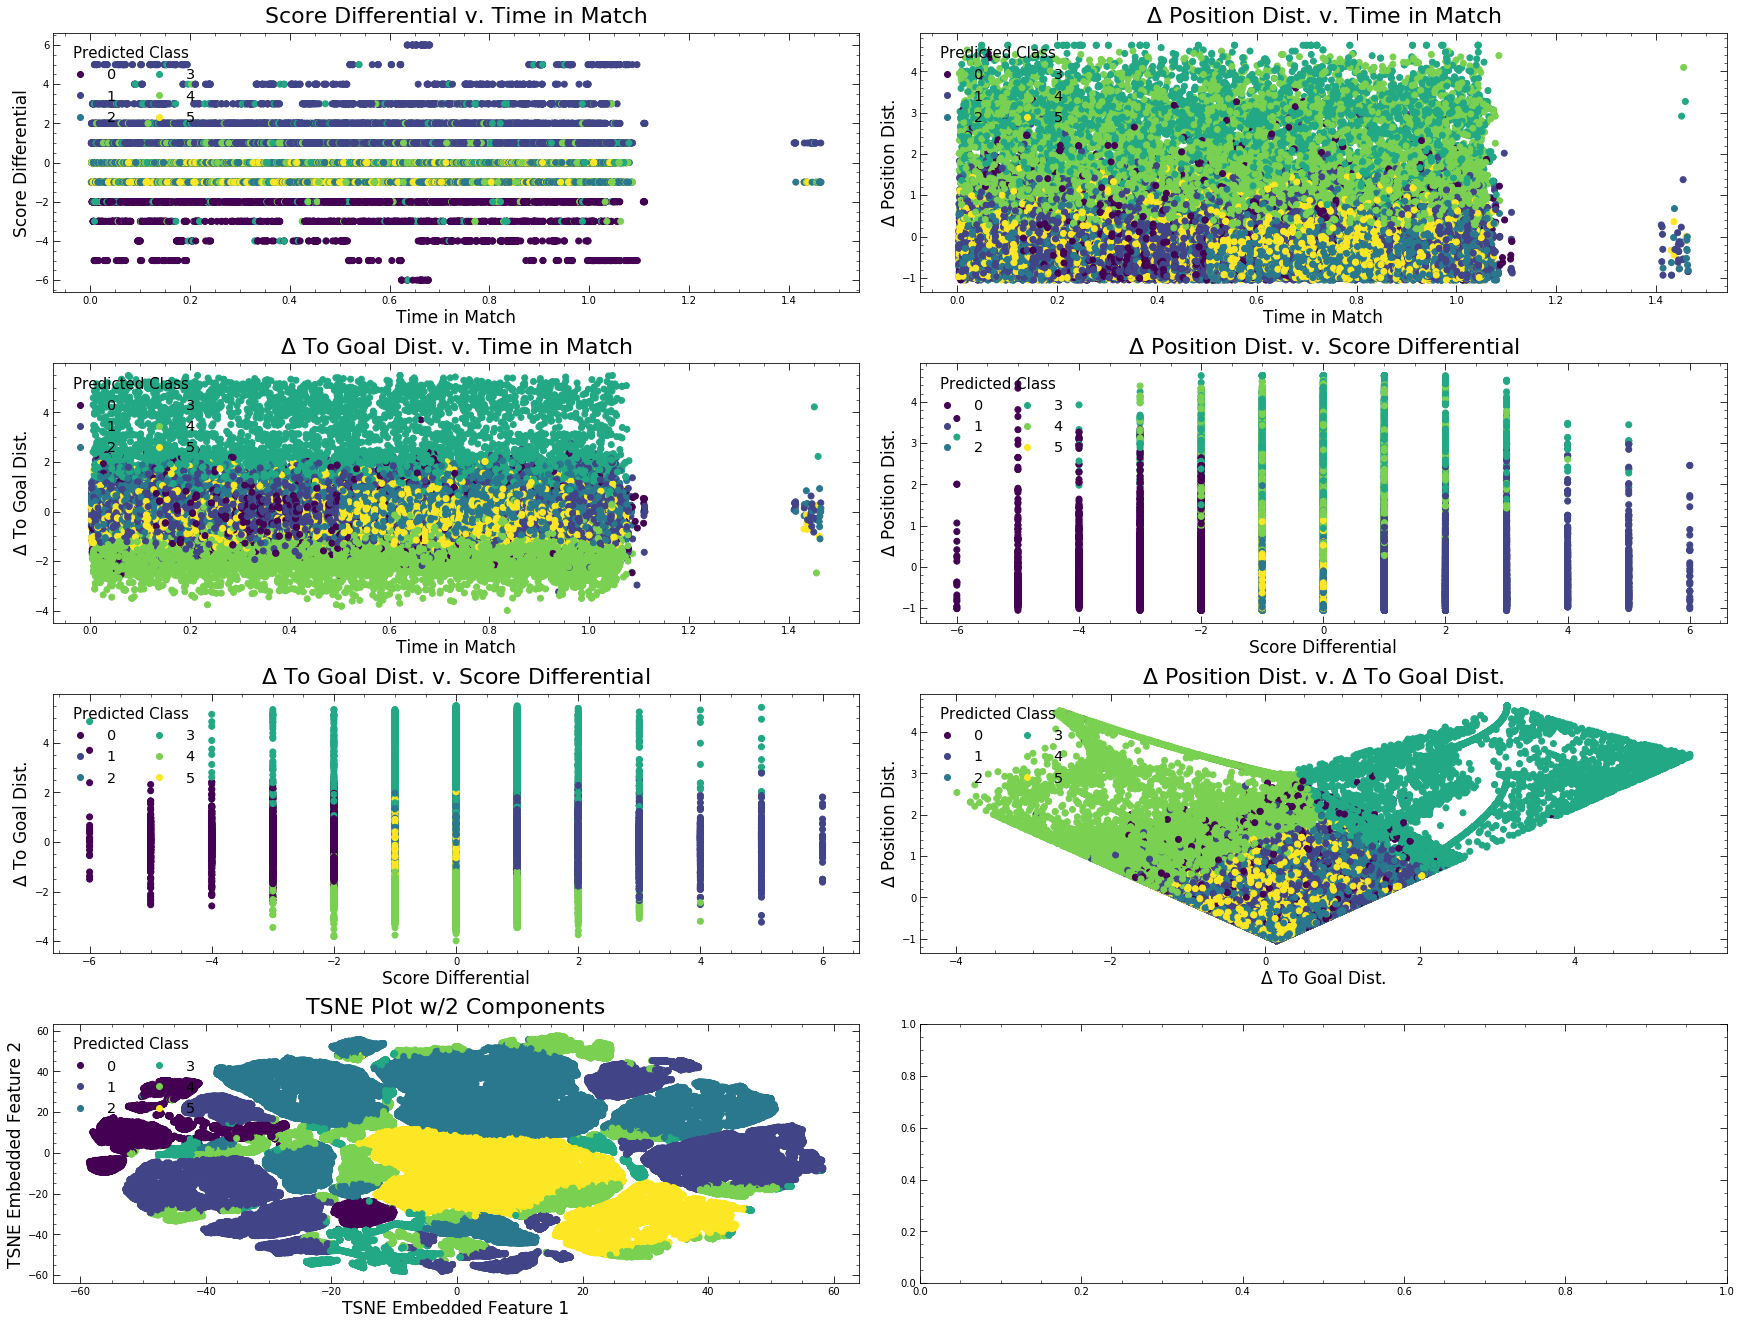

In [29]:
bv.cluster_subplot_generator(full_scaled_feats_arr[:100000:], 
                             scaled_prediction_arr[:100000:],
                             save_plot=True,
                             file_name="events_kmeans_scaled")

### Scaled Sequence-Wide K-Means

In [37]:
agg_scaled_k_means_predictions = best_k_means_agg_scaled.predict(agg_by_mean_scaled_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:442: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

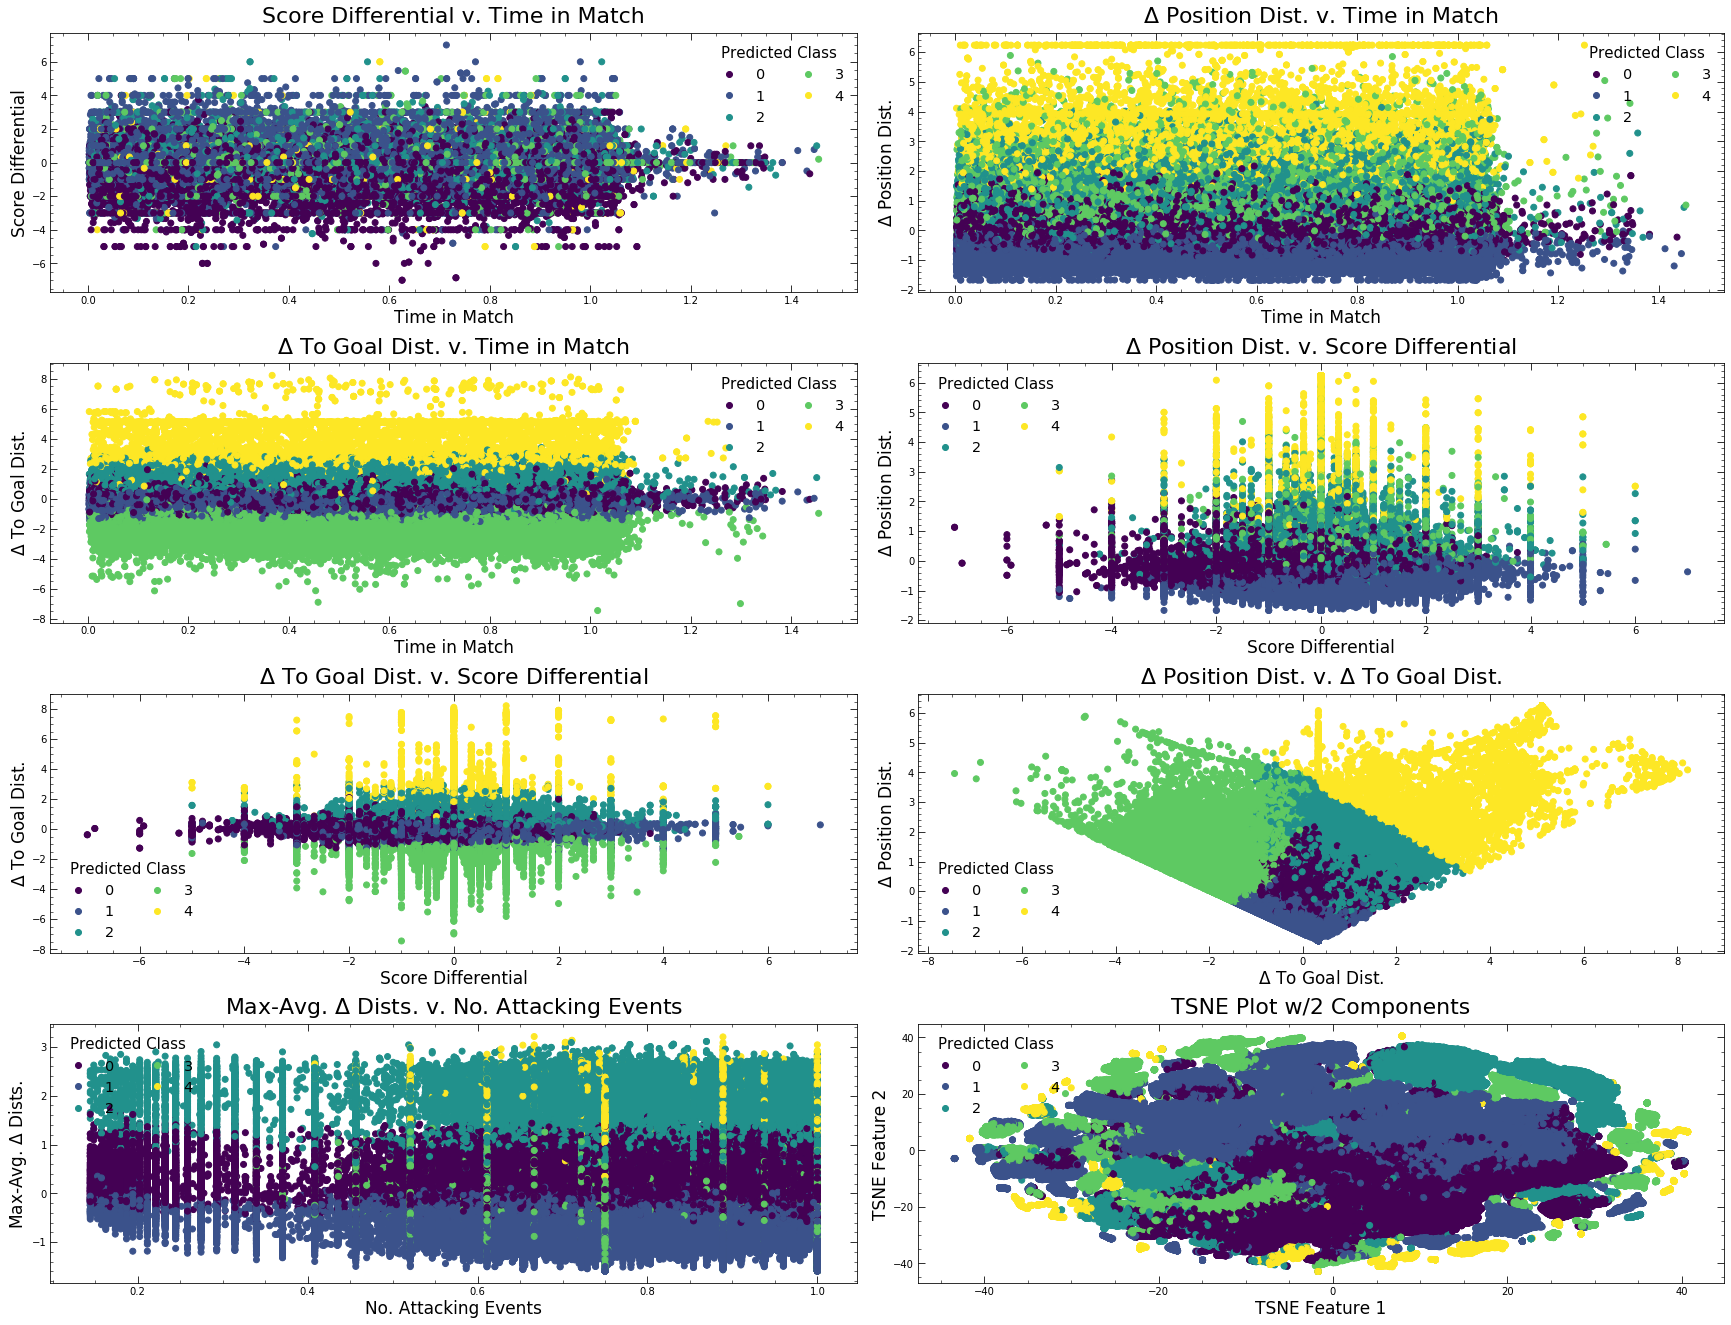

In [58]:
bv.cluster_subplot_generator(agg_by_mean_scaled_arr, 
                             agg_scaled_k_means_predictions,
                             save_plot=True,
                             file_name="seq_kmeans_scaled")

In [38]:
best_k_means_agg_scaled.cluster_centers_

array([[ 0.51758662, -0.17542186,  0.08765778,  0.30912398,  0.37958286,
         0.14400438,  0.00700825,  0.07995708,  0.78883882,  0.18476742],
       [ 0.51646066,  0.08396943,  0.03321538,  0.33841974,  0.42511376,
         0.15988877, -0.7062491 , -0.13465074,  0.81472215, -0.76760523],
       [ 0.5237676 ,  0.0960679 ,  0.09569116,  0.29514464,  0.33458689,
         0.15169932,  0.71166236,  0.82362067,  0.78195483,  1.75793943],
       [ 0.54840101,  0.04292424,  0.23666817,  0.24819441,  0.31578596,
         0.12992958,  0.84156162, -1.5975237 ,  0.78565531, -0.34399075],
       [ 0.54551484,  0.04278579,  0.26824329,  0.29073177,  0.15276798,
         0.13322704,  3.32524066,  3.20097048,  0.82255706,  1.90979097]])

In [39]:
distance_matrix = euclidean_distances(agg_by_mean_scaled_arr, best_k_means_agg_scaled.cluster_centers_)

In [40]:
closest_indicies = np.argmin(distance_matrix, axis=0)

In [41]:
closest_pts = agg_by_mean_scaled_arr[closest_indicies]

In [42]:
closest_pts_df = pd.DataFrame(
    closest_pts, 
    columns=["match_time", "score_diff", "is_goalie", "is_mid", "is_def", 
             "is_foward", "scaled_pos_delta_diff",  
             "scaled_to_goal_delta_diff", "num_attacking_events", 
             "scaled_delta_max_avg"]
)
closest_pts_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
0    0.585927         0.0   0.000000  0.333333  0.444444   0.111111   
1    0.602924         0.0   0.000000  0.375000  0.375000   0.250000   
2    0.537095         0.0   0.125000  0.125000  0.500000   0.250000   
3    0.657688         0.0   0.250000  0.250000  0.250000   0.000000   
4    0.394893         0.0   0.333333  0.333333  0.333333   0.000000   

   scaled_pos_delta_diff  scaled_to_goal_delta_diff  num_attacking_events  \
0              -0.020433                   0.118682              0.749603   
1              -0.789666                  -0.171334              0.794494   
2               0.739008                   0.861049              0.794494   
3               1.054658                  -1.602032              0.937500   
4               3.258643                   3.126715              0.888889   

   scaled_delta_max_avg  
0              0.107785  
1             -0.789313  
2              1.711701  
3             -0.383115  
4              2.191550

In [43]:
unscaled_series = closest_pts_df.apply(
    lambda x: std_scaler.inverse_transform([x.scaled_pos_delta_diff, 
                                            x.scaled_to_goal_delta_diff, 
                                            x.scaled_delta_max_avg]),
    axis="columns"
)

closest_pts_df["pos_delta_diff"] = unscaled_series.apply(lambda x: x[0])
closest_pts_df["to_goal_delta_diff"] = unscaled_series.apply(lambda x: x[1])
closest_pts_df["delta_max_avg"] = unscaled_series.apply(lambda x: x[2])

closest_pts_df.drop(columns=["scaled_pos_delta_diff", 
                             "scaled_to_goal_delta_diff", 
                             "scaled_delta_max_avg"])

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
0    0.585927         0.0   0.000000  0.333333  0.444444   0.111111   
1    0.602924         0.0   0.000000  0.375000  0.375000   0.250000   
2    0.537095         0.0   0.125000  0.125000  0.500000   0.250000   
3    0.657688         0.0   0.250000  0.250000  0.250000   0.000000   
4    0.394893         0.0   0.333333  0.333333  0.333333   0.000000   

   num_attacking_events  pos_delta_diff  to_goal_delta_diff  delta_max_avg  
0              0.749603       29.454189           -2.768001      43.874634  
1              0.794494       15.693600           -6.519619      20.685399  
2              0.794494       43.039628            6.835220      85.334517  
3              0.937500       48.686184          -25.027042      31.185284  
4              0.888889       88.112656           36.143732      97.738188

In the DataFrame displayed by the cell imediately above we can see the data points in our data set that are closeset to the centroids of the clusters that were indentified by the K-Means model trained on the scaled version of the sequence-wide training data. With this, we can begin to characterize these model-identified clusters. **Here's what we can gather so far about each cluster**:
1. These events tend to occur in the first 5-10 minutes of the second half and are executed by non-goalie players. The distribution of player position is skewed towards midfields and defenders while at the same time having the second highest distance movement among the cluster. This could indicate that these are set pieces that begin from non-goalie free kicks and throw-ins around the middle of the field. Pass sequences in this part of the field are prone to include backwards (away from the opposition's goal) passes and momentarily cause posession to change teams which would explain the values of the `num_attacking_events` and `to_goal_delta_diff` features.
2. These events also include no goalie-initiated ones while also having the smallest value for distance advancement. It also has the highest proportion of forward-initiated events and the lowest value for the `to_goal_delta_dff`. One likely explanation for all of these cluster characeristics is that this is a collection of the set piece sequences whose events occur in the attacking third (or so) of the pitch. This would easily explain the `is_foward` and `pos_delta_diff` values since this is the part of the field in which the fowards play and there is not much more field to work with to advance the ball. One could make sense of the value for `to_goal_delta_diff` since the defending team would be more apt to "clear" the ball when given the chance so as to best avoid a goal being score by the attacking team; this sort of pass tends to be long so as to get the ball as far away from the defense's goal as possible. These events also occuring later in the game also make sense since, as established when talking about the first cluster, teams are more aggressive in the second half.
3. These events occur very soon after half time and have the more flat distribution across player positions among the clusters. They are also fairly high distance events and make a fair significance towards the goal. The goalie kicks that are not in the last cluster are likely in this one and we also have a fairly high number of free kicks around midfield. One explanation for this overlap is that what difference this cluster from the last one is the time in the match (i.e., first half v. second half).
4. This cluster includes that events that are latest in the match while not having any forward participation. We also see the highest proportion of events initiated by the attacking team in this cluster while having the lowest value for `to_goal_delta_diff`. Despite the very low value for this feature, we still have a decently high value for the `delta_max_avg` feature thanks to a pretty high value for the `pos_delta_diff` feature. From this we can conclude that the events are mainly passes in the attacking team's own half of the pitch and the higher possession rate is possibly because of the defense's perfence towards laying back in anticipation of a more aggressive attack from the opposition. As we already discussed for the first cluster, events in a team's own half of the fields are prone to go backwards given the team's conservative approach in this half of the field so as to avoid a turnover that would lead to a dangerous counter-attack.
5. These events yield the longest passes while also have the highest proportion of events initiated by the goalie. This is a tell-tale sign that this cluster mainly includes goalie kicks. This conclusion is also supported by the fact that this cluster is one of two in which the most characteristic sequence had no events were initiated by forwards. This is because defenders and midfielders are the players that are most likely to catch goalie kicks and then initiate the events immediately following them given their positioning on the field. We could be even more confident in our conclusion if we had a "length of sequence" feature and the value for it was a very small integer; this is because set piece sequences starting from goalie kick are also a bit high risk since it's just a "50/50" ball in the air that is up for grabs leading to only a few attacking events. The time in the match in which these events occur also makes sense since teams are less aggressive early on meaning they play out of their own third of the field making them more likely to initiate goal kick set pieces.

**General observations (i.e., across the clusters) include:**
1. All clusters with the exception of the last one all include events that happen in the second half. This is a bit surprising at first, but it does tend to make sense given that since more goals tend to be scored in the second half of soccer matches, we can conclude that teams are more aggressive in that half which would inevitably lead to more set pieces (i.e., because of more fouls from defenses, more events in the box leading to more corners and free kicks, etc...). 
2. The average value of the score differential is 0 across each cluster. This is likely a result of soccer matches predominately being closely contested forcing the mean in general of the `score_diff` to be around zero. Thus, this feature is perhaps not as informative (compared to the others included) as we may have initially hoped.

### Unscaled Sequenec-Wide K-Means

In [140]:
agg_unscaled_k_means_predictions = best_k_means_agg_unscaled.predict(aggregated_by_mean_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:447: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



<Figure size 432x288 with 0 Axes>

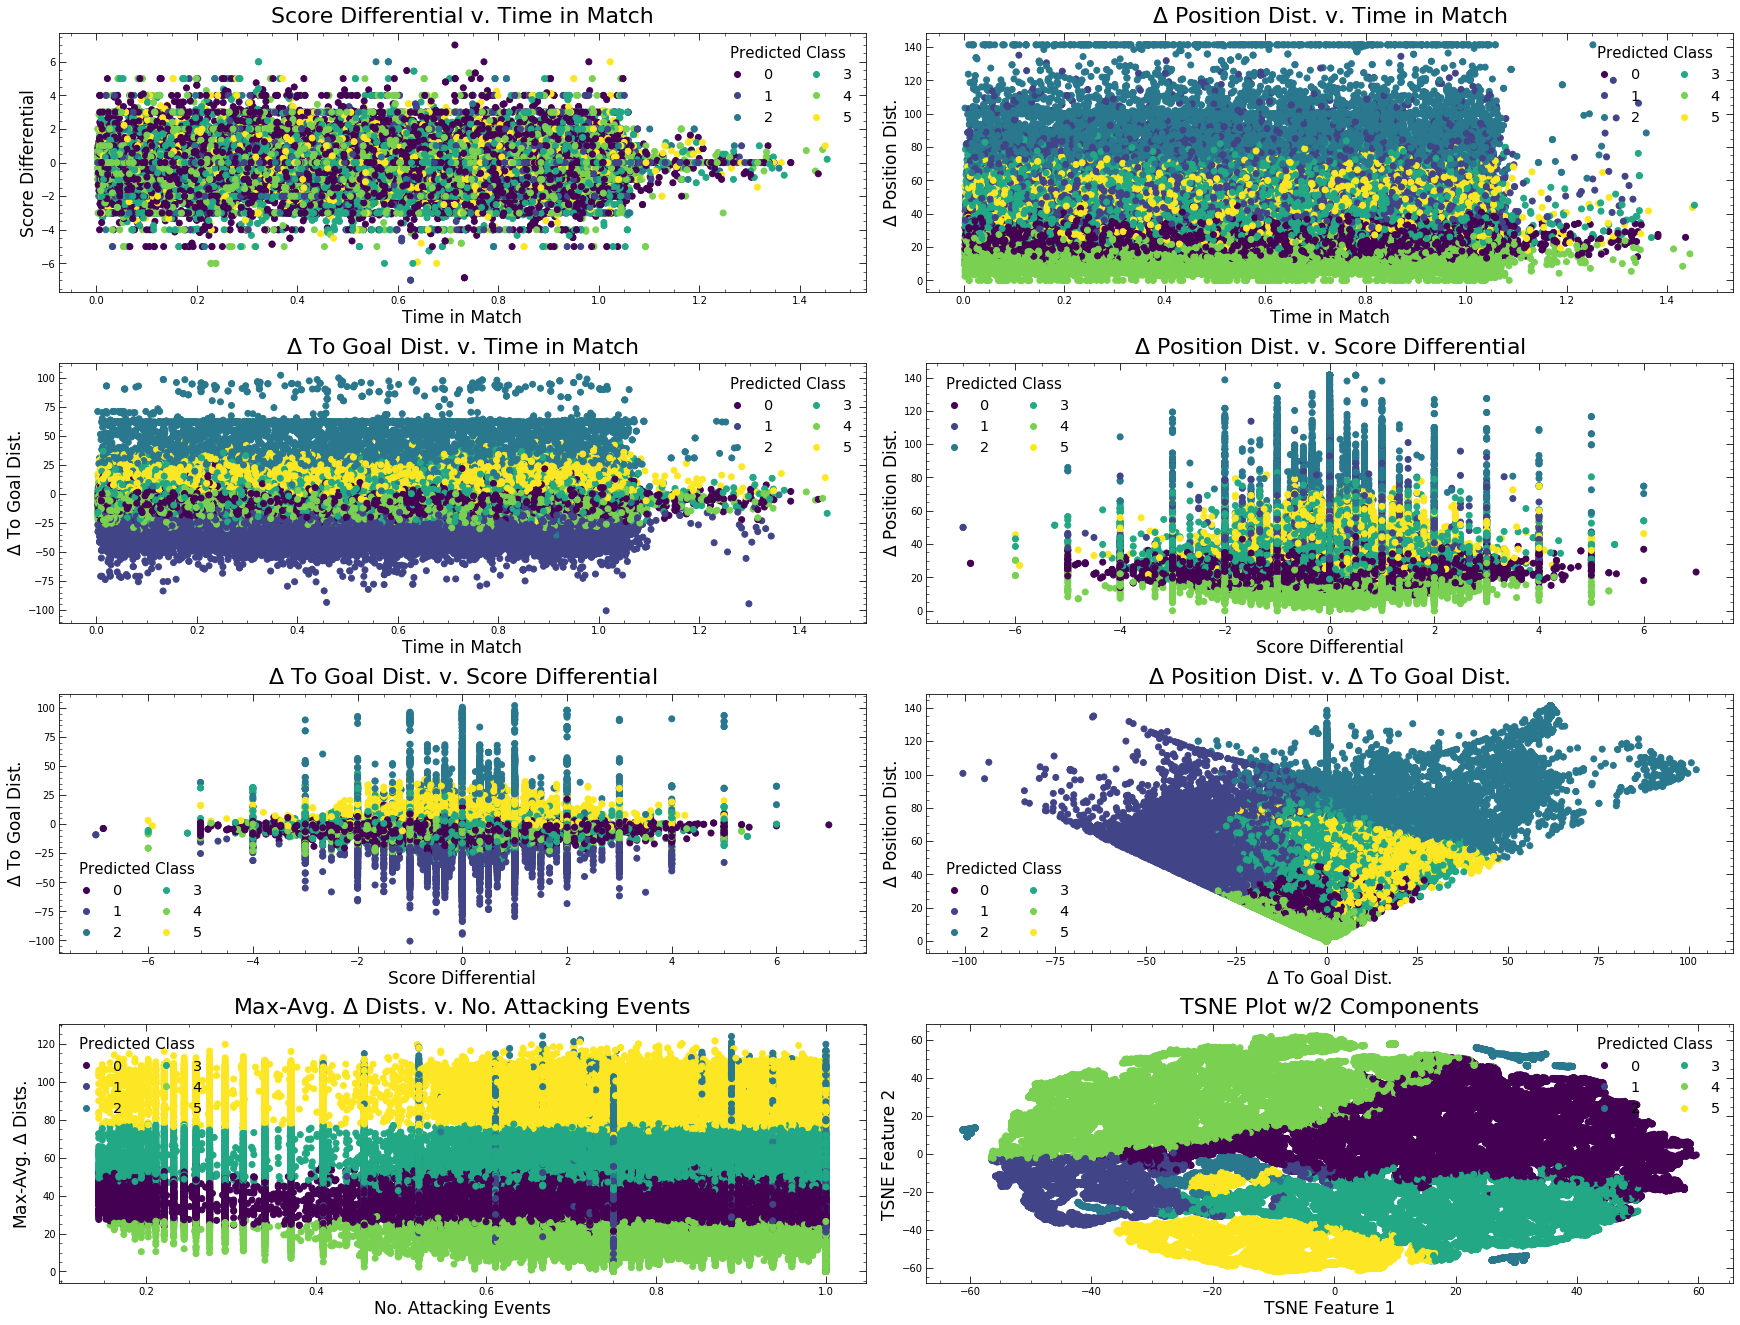

In [146]:
bv.cluster_subplot_generator(aggregated_by_mean_arr, 
                             agg_unscaled_k_means_predictions,
                             save_plot=True,
                             file_name="seq_kmeans_unscaled")

### Scaled Sequence-Wide Mean-Shift

In [40]:
agg_scaled_mean_shift_predictions = mean_shift_agg_scaled.predict(agg_by_mean_scaled_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


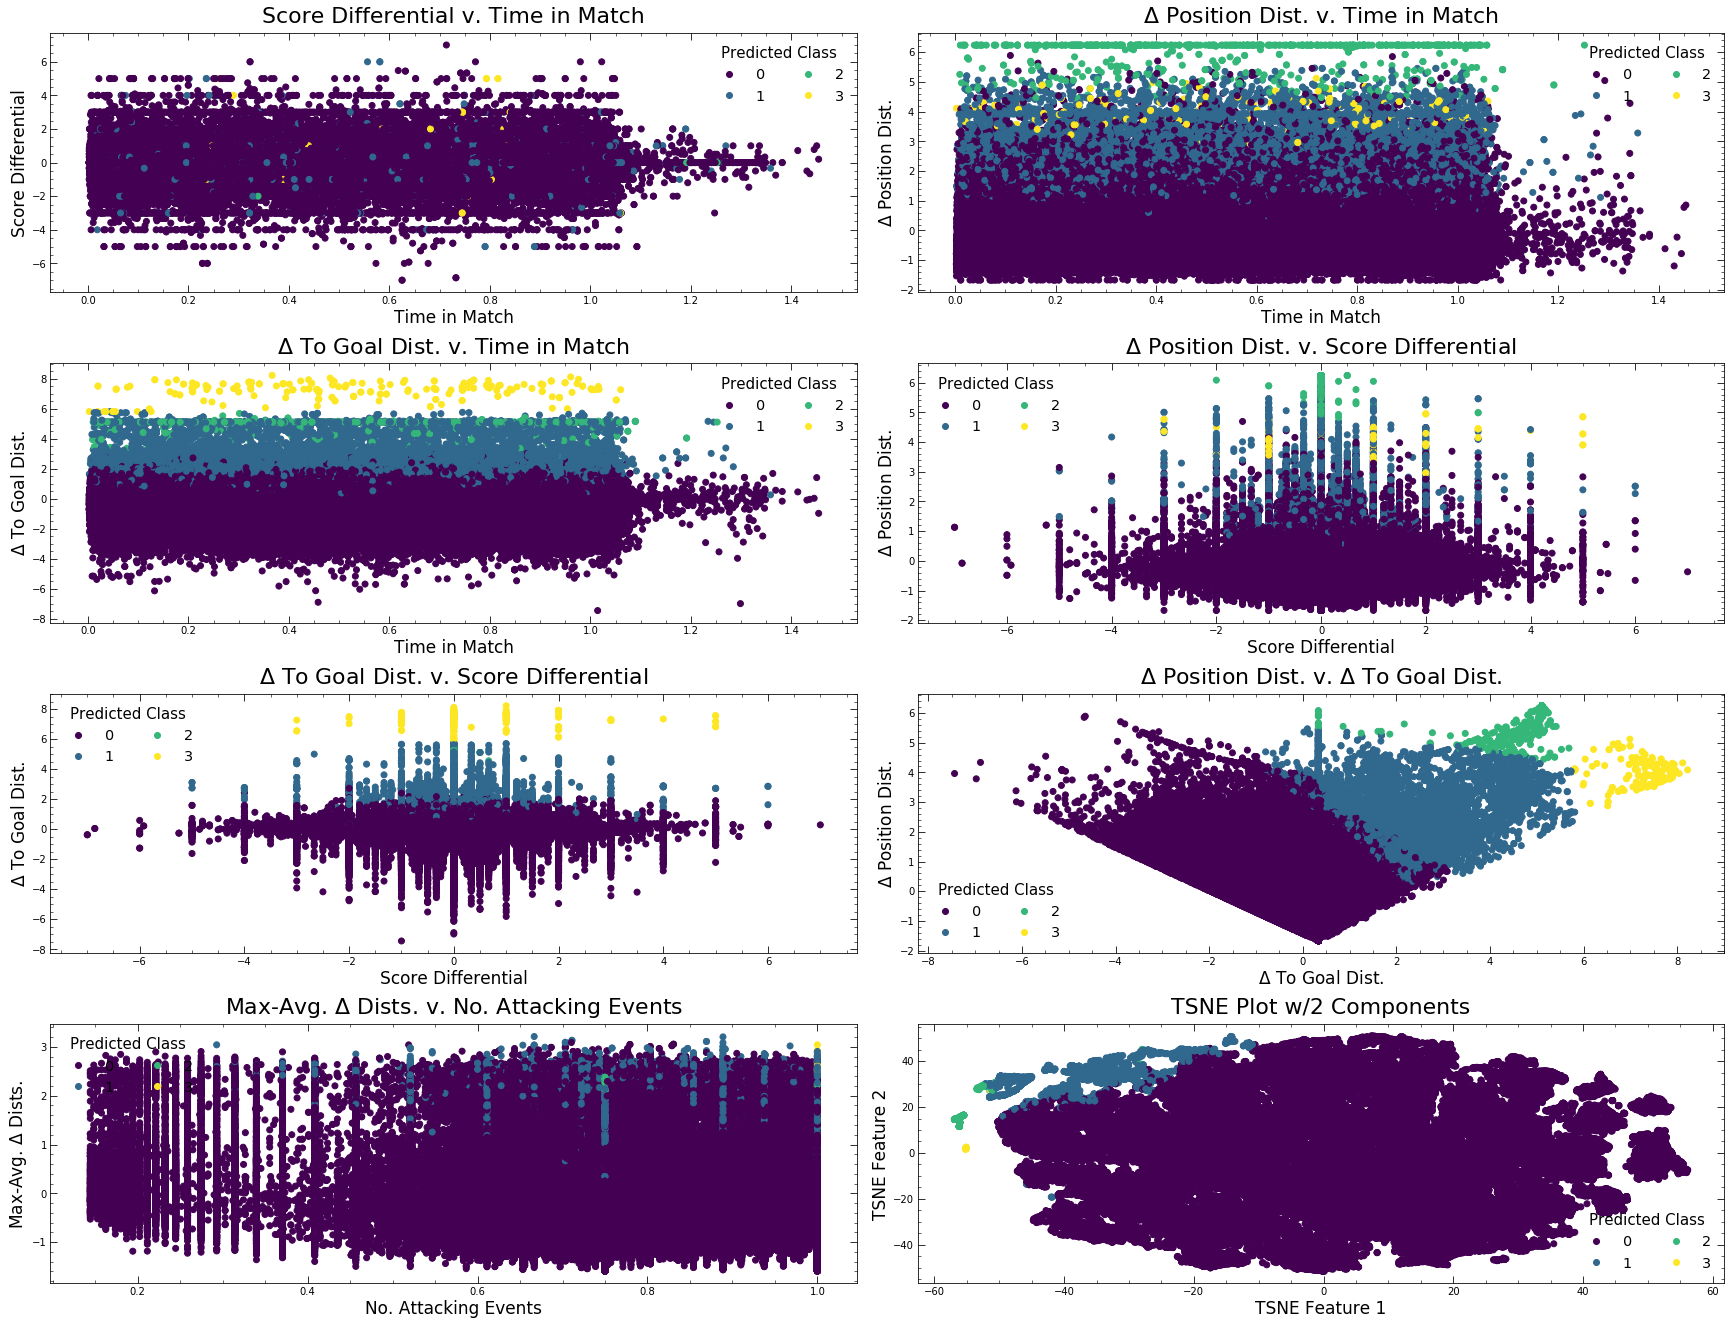

In [41]:
bv.cluster_subplot_generator(agg_by_mean_scaled_arr, 
                             agg_scaled_mean_shift_predictions,
                             save_plot=True,
                             file_name="seq_mean_shift_scaled")

### Unscaled Sequence-Wide Mean-Shift

In [ ]:
agg_unscaled_mean_shift_predictions = mean_shift_agg_unscaled.predict(aggregated_by_mean_arr)

In [ ]:
bv.cluster_subplot_generator(aggregated_by_mean_arr, 
                             agg_unscaled_mean_shift_predictions,
                             save_plot=True,
                             file_name="seq_mean_shift_unscaled")

# Deeper Analysis of Each Cluster

### Scaled Sequence-Wide K-Means

In [44]:
scaled_seq_k_means_df = pd.DataFrame(
    np.hstack([agg_by_mean_scaled_arr, 
               agg_scaled_k_means_predictions.reshape(-1, 1)]),
    columns=["match_time", "score_diff", "is_goalie", "is_mid", "is_def", 
             "is_foward", "pos_delta_diff", "to_goal_delta_diff",  
             "num_attacking_events", "delta_max_avg", "predicted_cluster_id"],
    index=aggregated_by_mean_df.index
)
scaled_seq_k_means_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
seq_id                                                                     
100       1.412520    0.714286   0.142857  0.142857  0.571429   0.000000   
101       1.430684   -0.500000   0.000000  0.000000  0.500000   0.500000   
102       1.436421   -0.666667   0.000000  0.333333  0.666667   0.000000   
103       1.445103    0.777778   0.000000  0.555556  0.222222   0.111111   
104       1.450213    1.000000   0.000000  0.250000  0.250000   0.500000   
...            ...         ...        ...       ...       ...        ...   
275426    0.921815    0.111111   0.000000  0.333333  0.500000   0.111111   
275427    0.987549    1.000000   0.000000  0.200000  0.200000   0.600000   
275428    0.705332    0.000000   0.333333  0.666667  0.000000   0.000000   
275429    0.806697    0.333333   0.000000  0.166667  0.583333   0.083333   
275430    0.812196    0.000000   0.000000  0.000000  0.500000   0.500000   

        pos_delta_diff  to_goal_delta_diff  num_attacking_events  \
seq_id                                                             
100          -0.613724            0.460742              0.979592   
101          -1.193171           -0.083215              0.937500   
102          -0.223462           -0.032926              0.972222   
103          -0.778276            0.037384              0.987654   
104           0.777798            1.413016              1.000000   
...                ...                 ...                   ...   
275426       -0.264974            0.242210              0.946789   
275427       -0.225275           -0.750145              1.000000   
275428        1.199798            0.811350              0.888889   
275429        0.084178            1.145646              0.803526   
275430        0.116788           -1.667374              0.750000   

        delta_max_avg  predicted_cluster_id  
seq_id                                       
100         -0.850478                   1.0  
101         -1.190912                   1.0  
102         -0.479912                   0.0  
103         -0.846178                   1.0  
104          1.954581                   2.0  
...               ...                   ...  
275426       1.333055                   2.0  
275427      -0.425317                   1.0  
275428       0.756329                   2.0  
275429       2.440341                   2.0  
275430      -0.960954                   3.0  

[275331 rows x 11 columns]

In [168]:
cluster_events_df

seq_id         id                                  positions  matchId  \
0          102  198792438   [{'y': 87, 'x': 45}, {'y': 74, 'x': 23}]  2576040   
1          102  198792439   [{'y': 74, 'x': 23}, {'y': 39, 'x': 26}]  2576040   
2          102  198792441   [{'y': 39, 'x': 26}, {'y': 34, 'x': 40}]  2576040   
3          102  198792443   [{'y': 34, 'x': 40}, {'y': 77, 'x': 40}]  2576040   
4          102  198792446   [{'y': 77, 'x': 40}, {'y': 71, 'x': 57}]  2576040   
...        ...        ...                                        ...      ...   
731156  275421  249966019  [{'y': 0, 'x': 87}, {'y': 100, 'x': 100}]  2565898   
731157  275422  249965559  [{'y': 100, 'x': 15}, {'y': 93, 'x': 35}]  2565898   
731158  275422  247596990     [{'y': 0, 'x': 0}, {'y': 93, 'x': 22}]  2565889   
731159  275422  247596991   [{'y': 93, 'x': 22}, {'y': 93, 'x': 26}]  2565889   
731160  275422  247597442     [{'y': 7, 'x': 78}, {'y': 7, 'x': 74}]  2565889   

        teamId  
0         3176  
1         3176  
2         3176  
3         3176  
4         3176  
...        ...  
731156     698  
731157     714  
731158     677  
731159     677  
731160     676  

[731161 rows x 5 columns]

In [169]:
pos_binning_results = cpp.cluster_positions_binning(
    cluster_positions_df=cpp.cluster_positions_extractor(cluster_events_df),
    beginning_points=True
)

In [178]:
pos_binning_results[2]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

<Figure size 432x288 with 0 Axes>

(<Figure size 1440x936 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8338900a90>)

<Figure size 432x288 with 0 Axes>

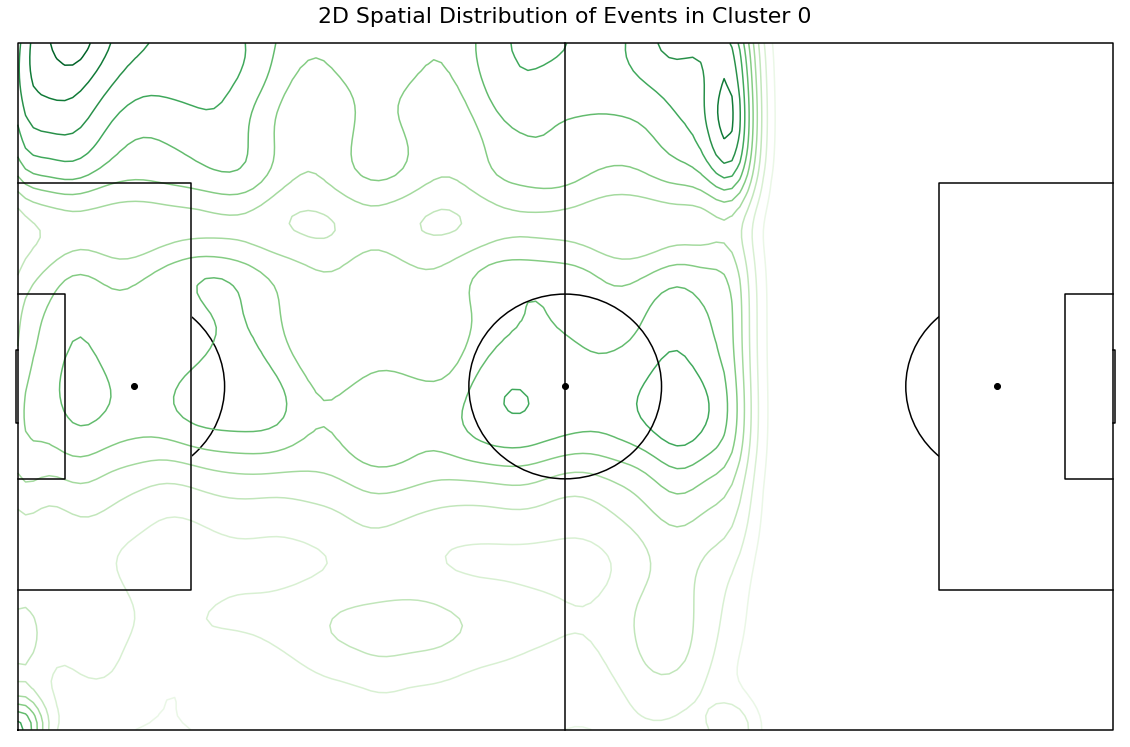

In [213]:
pp.pitch_positions_cluster_generator(
    feat_pred_df=scaled_seq_k_means_df,
    cluster_id=0,
    save_plot=True,
    file_name="Spatial_Dist_0"
)

(<Figure size 1440x936 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8336f5cf50>)

<Figure size 432x288 with 0 Axes>

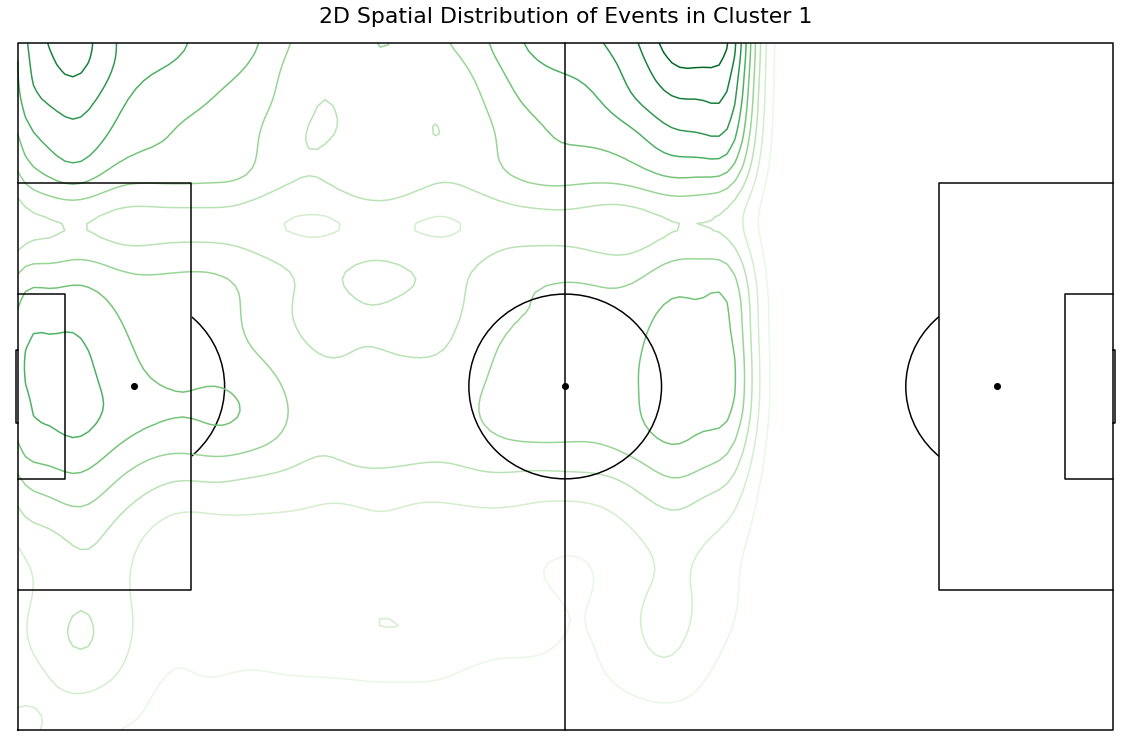

In [214]:
pp.pitch_positions_cluster_generator(
    feat_pred_df=scaled_seq_k_means_df,
    cluster_id=1,
    save_plot=True,
    file_name="Spatial_Dist_1"
)

(<Figure size 1440x936 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8339883b50>)

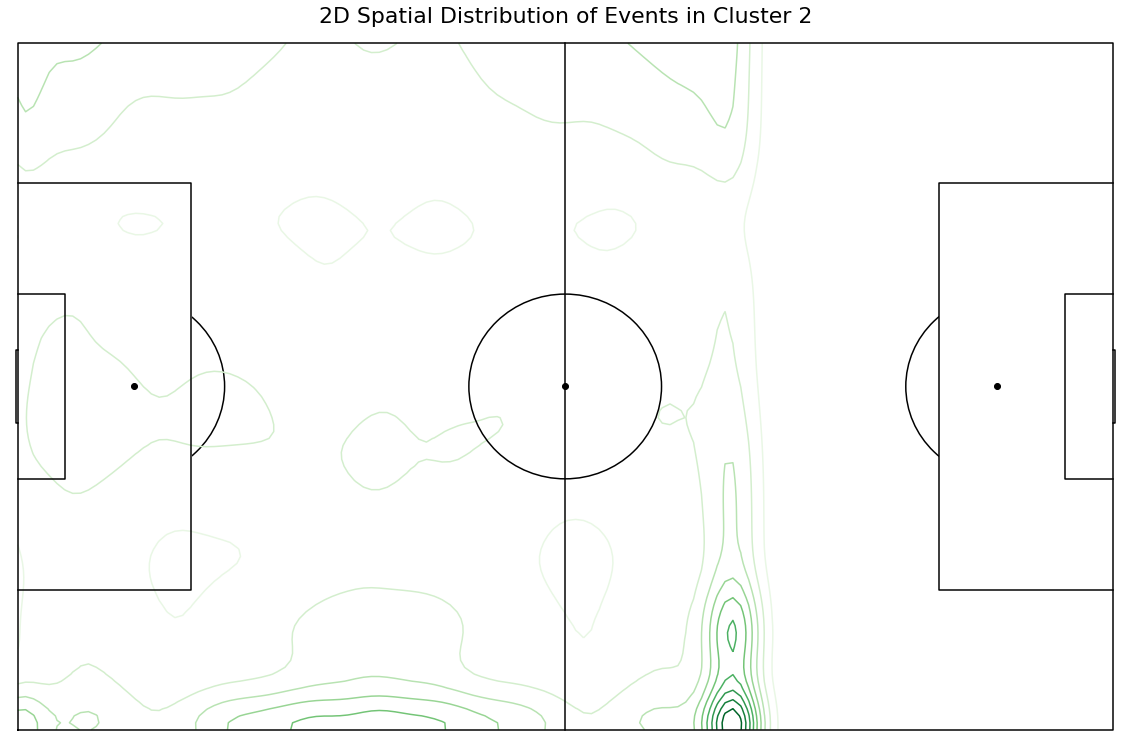

In [215]:
pp.pitch_positions_cluster_generator(
    feat_pred_df=scaled_seq_k_means_df,
    cluster_id=2,
    save_plot=True,
    file_name="Spatial_Dist_2"
)

(<Figure size 1440x936 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8339315d10>)

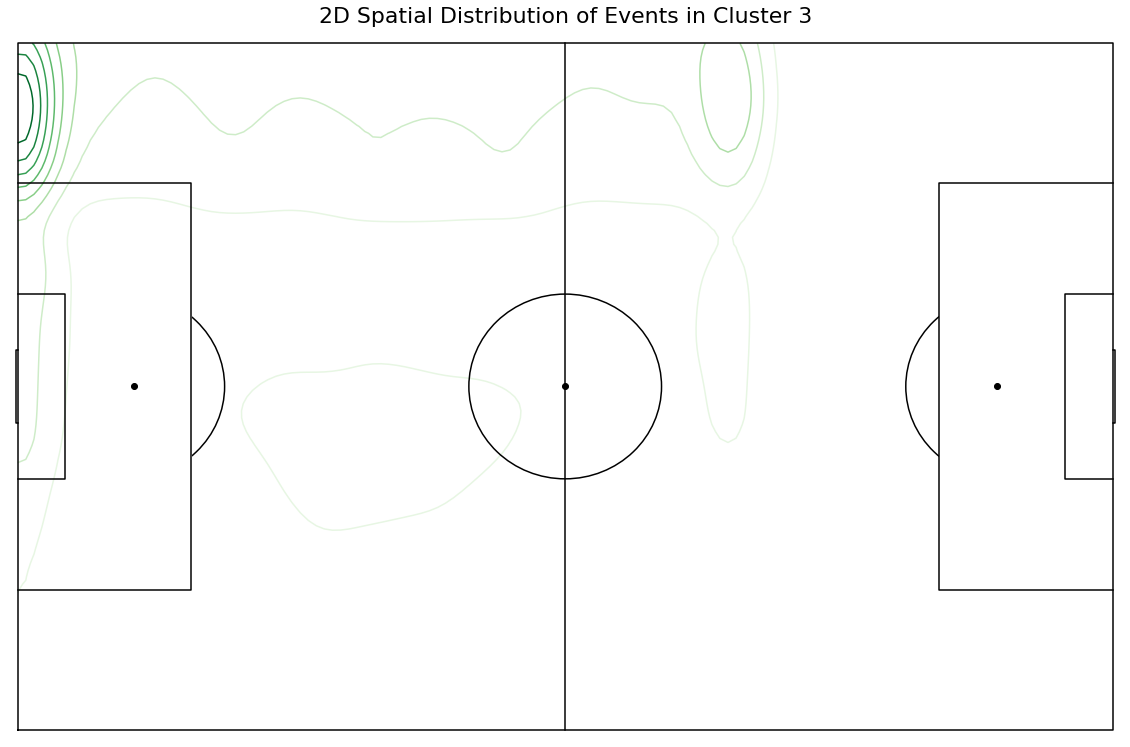

In [216]:
pp.pitch_positions_cluster_generator(
    feat_pred_df=scaled_seq_k_means_df,
    cluster_id=3,
    save_plot=True,
    file_name="Spatial_Dist_3"
)

(<Figure size 1440x936 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8338f5b450>)

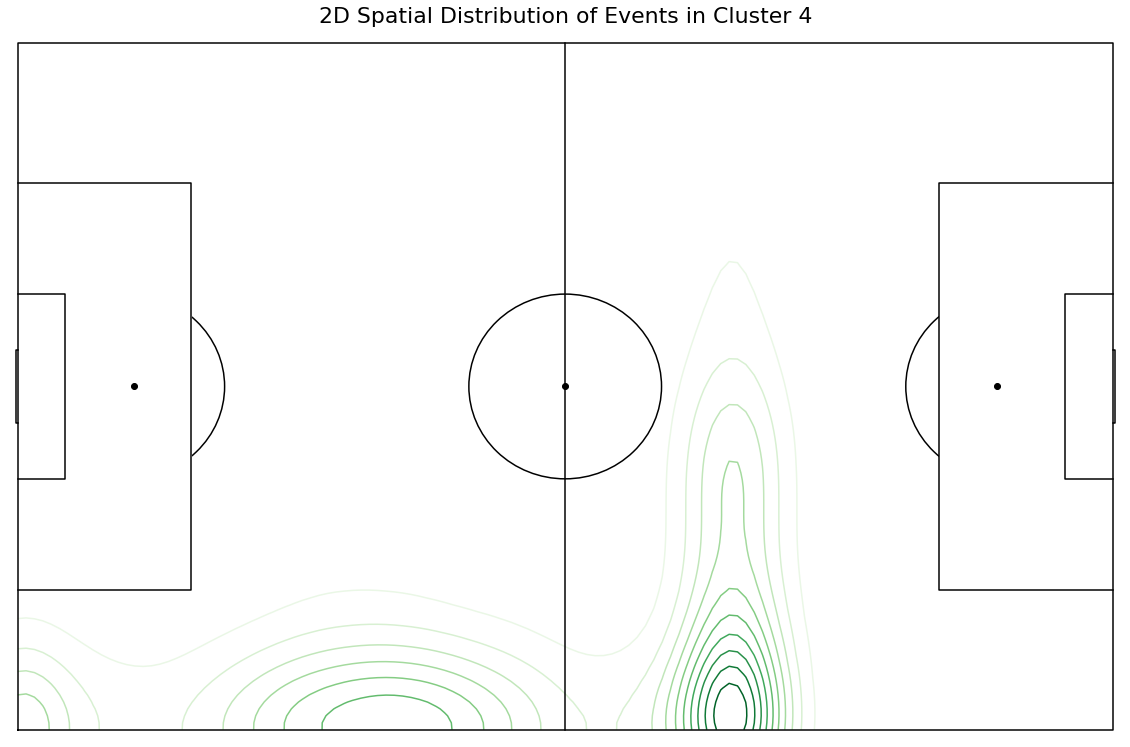

In [217]:
pp.pitch_positions_cluster_generator(
    feat_pred_df=scaled_seq_k_means_df,
    cluster_id=4,
    save_plot=True,
    file_name="Spatial_Dist_4"
)

In [191]:
scaled_seq_k_means_df.predicted_cluster_id.value_counts()

1.0    113191
0.0     86141
2.0     37458
3.0     30403
4.0      8138
Name: predicted_cluster_id, dtype: int64

<Figure size 432x288 with 0 Axes>

In [46]:
scaled_seq_k_means_df.index.name

'seq_id'

In [48]:
sequences_with_scores_df.head()

id  eventId subEventName            tags  playerId  \
0  198792553        3    Free Kick  [{'id': 1801}]         0   
1  198792554        8  Simple pass  [{'id': 1801}]     50007   
2  198792555        8  Simple pass  [{'id': 1801}]     24838   
3  198792556        8  Simple pass  [{'id': 1801}]     21415   
4  198792557        8  Simple pass  [{'id': 1801}]    284960   

                                  positions  matchId  eventName  teamId  \
0  [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040  Free Kick    3219   
1  [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040       Pass    3219   
2  [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040       Pass    3219   
3  [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040       Pass    3219   
4  [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040       Pass    3219   

  matchPeriod     eventSec  subEventId  seq_id score  
0          2H  2216.339790        31.0     100   0-1  
1          2H  2221.716912        85.0     100   0-1  
2          2H  2225.150837        85.0     100   0-1  
3          2H  2228.885593        85.0     100   0-1  
4          2H  2231.951066        85.0     100   0-1

In [50]:
cluster0_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 0)

cluster1_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 1)

cluster2_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 2)

cluster3_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 3)

cluster4_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 4)

In [51]:
cluster0_event_types_df

eventId     eventName  subEventId           subEventName
seq_id                                                          
102           3     Free Kick        31.0              Free Kick
102           8          Pass        85.0            Simple pass
102           8          Pass        85.0            Simple pass
102           8          Pass        85.0            Simple pass
102           8          Pass        85.0            Simple pass
...         ...           ...         ...                    ...
275421        5  Interruption        50.0  Ball out of the field
275422        3     Free Kick        36.0               Throw in
275422        3     Free Kick        34.0              Goal kick
275422        1          Duel        11.0  Ground attacking duel
275422        1          Duel        12.0  Ground defending duel

[731161 rows x 4 columns]

In [52]:
cluster0_event_types_counts = cbcp.cluster_counts(cluster0_event_types_df)
cluster1_event_types_counts = cbcp.cluster_counts(cluster1_event_types_df)
cluster2_event_types_counts = cbcp.cluster_counts(cluster2_event_types_df)
cluster3_event_types_counts = cbcp.cluster_counts(cluster3_event_types_df)
cluster4_event_types_counts = cbcp.cluster_counts(cluster4_event_types_df)

In [53]:
cluster3_event_types_counts[0]

event_name  event_count  nevent_count
0                     Duel        17242      0.198031
1                     Foul          198      0.002274
2                Free Kick        37197      0.427223
3  Goalkeeper leaving line          223      0.002561
4             Interruption         3288      0.037764
5                  Offside          133      0.001528
6       Others on the ball         6185      0.071037
7                     Pass        22328      0.256446
8             Save attempt          158      0.001815
9                     Shot          115      0.001321

In [54]:
cluster3_event_types_counts[1]

sub_event_name  sub_event_count  nsub_event_count
0              Acceleration              224          0.002577
1                  Air duel            11720          0.134815
2     Ball out of the field             3281          0.037741
3                 Clearance             4352          0.050061
4                    Corner             4844          0.055720
5                     Cross             1100          0.012653
6                      Foul              178          0.002048
7                 Free Kick             9606          0.110498
8           Free kick cross             2448          0.028159
9            Free kick shot              183          0.002105
10                Goal kick            11883          0.136690
11  Goalkeeper leaving line              223          0.002565
12    Ground attacking duel             1318          0.015161
13    Ground defending duel             1541          0.017726
14   Ground loose ball duel             2663          0.030632
15                Hand foul               14          0.000161
16                Hand pass              185          0.002128
17                Head pass             5696          0.065521
18                High pass             4701          0.054076
19           Late card foul                0          0.000000
20                   Launch             2848          0.032760
21                  Offside                0          0.000000
22         Out of game foul                2          0.000023
23                  Penalty               57          0.000656
24                  Protest                3          0.000035
25                 Reflexes               41          0.000472
26             Save attempt              117          0.001346
27                     Shot              115          0.001323
28              Simple pass             7381          0.084903
29               Simulation                0          0.000000
30               Smart pass              417          0.004797
31                 Throw in             8176          0.094048
32           Time lost foul                1          0.000012
33                    Touch             1609          0.018508
34             Violent Foul                0          0.000000
35                  Whistle                7          0.000081

#### Event and Sub-Event Types Histogram For Each Cluster

In [64]:
# merge across all of the clusters in order to compute the data-wide
# count values for all of the possible event and sub-event types.
event_types_counts_cat = pd.concat(
    objs=[cluster0_event_types_counts[0],
          cluster1_event_types_counts[0],
          cluster2_event_types_counts[0],
          cluster3_event_types_counts[0],
          cluster4_event_types_counts[0],],
    ignore_index=True
)

sub_event_types_counts_cat = pd.concat(
    objs=[cluster0_event_types_counts[1],
          cluster1_event_types_counts[1],
          cluster2_event_types_counts[1],
          cluster3_event_types_counts[1],
          cluster4_event_types_counts[1],],
    ignore_index=True
)
event_types_counts_cat.head()

event_name  event_count  nevent_count
0                     Duel       175225      0.239653
1                     Foul         5006      0.006847
2                Free Kick        99389      0.135933
3  Goalkeeper leaving line         1001      0.001369
4             Interruption        25685      0.035129

In [70]:
sub_event_types_counts_cat.head()

sub_event_name  sub_event_count  nsub_event_count
0           Acceleration             2621          0.003594
1               Air duel            52786          0.072384
2  Ball out of the field            25552          0.035039
3              Clearance            14023          0.019229
4                 Corner             9968          0.013669

In [75]:
event_types_counts = event_types_counts_cat.groupby(
    by="event_name"
).sum().reset_index(drop=False).drop(columns="nevent_count")
sub_event_types_counts = sub_event_types_counts_cat.groupby(
    by="sub_event_name"
).sum().reset_index(drop=False).drop(columns="nsub_event_count")

event_types_counts["nevent_count"] = event_types_counts.event_count / event_types_counts.event_count.sum()
sub_event_types_counts["nsub_event_count"] = sub_event_types_counts.sub_event_count / sub_event_types_counts.sub_event_count.sum()

assert np.isclose(event_types_counts.nevent_count.sum(), 1)
assert np.isclose(sub_event_types_counts.nsub_event_count.sum(), 1)

event_types_counts

event_name  event_count  nevent_count
0                     Duel       500683      0.264753
1                     Foul        22698      0.012002
2                Free Kick       311098      0.164503
3  Goalkeeper leaving line         5384      0.002847
4             Interruption        57616      0.030466
5                  Offside         4691      0.002481
6       Others on the ball       127056      0.067185
7                     Pass       827446      0.437540
8             Save attempt         8240      0.004357
9                     Shot        26222      0.013866

In [76]:
sub_event_types_counts.head(n=15)

sub_event_name  sub_event_count  nsub_event_count
0              Acceleration             6686          0.003544
1                  Air duel           129486          0.068640
2     Ball out of the field            57378          0.030416
3                 Clearance            37058          0.019644
4                    Corner            32082          0.017007
5                     Cross            38907          0.020625
6                      Foul            21124          0.011198
7                 Free Kick            75064          0.039791
8           Free kick cross            14933          0.007916
9            Free kick shot             3634          0.001926
10                Goal kick            50159          0.026589
11  Goalkeeper leaving line             5384          0.002854
12    Ground attacking duel           140392          0.074422
13    Ground defending duel           146496          0.077657
14   Ground loose ball duel            84309          0.044692

In [80]:
cluster0_event_types_counts[0].set_index("event_name") - event_types_counts.set_index("event_name")

event_count  nevent_count
event_name                                        
Duel                         -325458     -0.025100
Foul                          -17692     -0.005156
Free Kick                    -211709     -0.028570
Goalkeeper leaving line        -4383     -0.001478
Interruption                  -31931      0.004663
Offside                        -2778      0.000136
Others on the ball            -76690      0.001700
Pass                         -467415      0.054870
Save attempt                   -6296     -0.001698
Shot                          -15621      0.000633

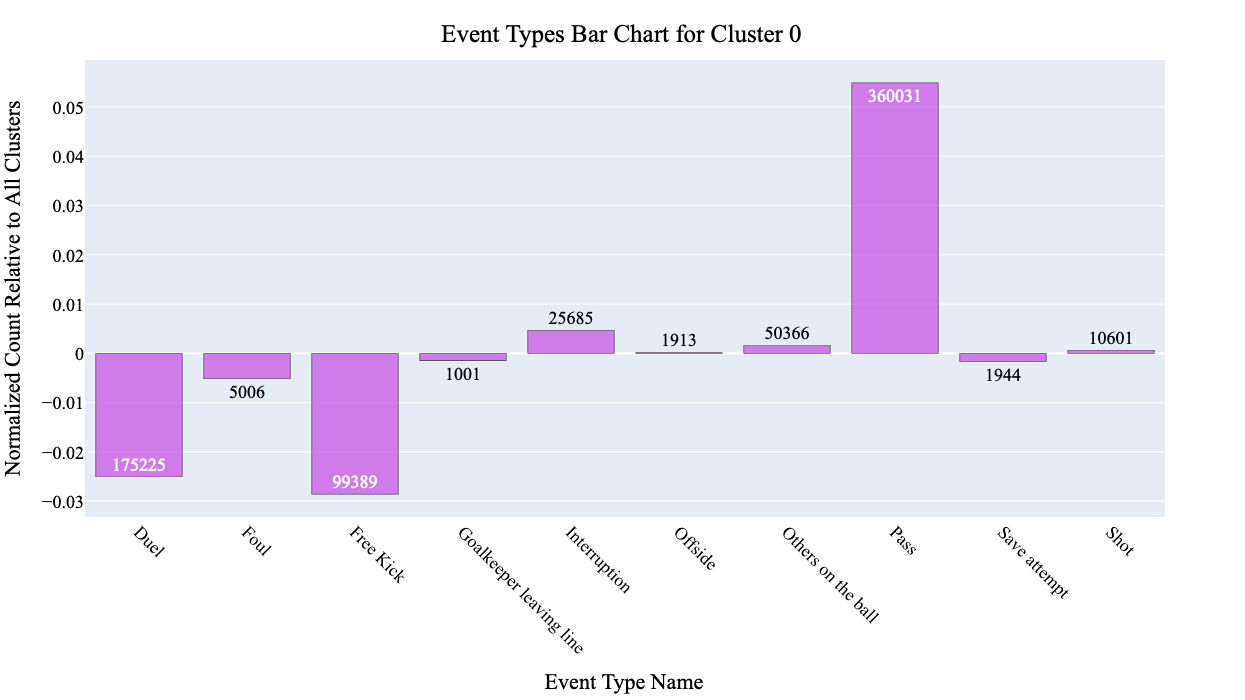

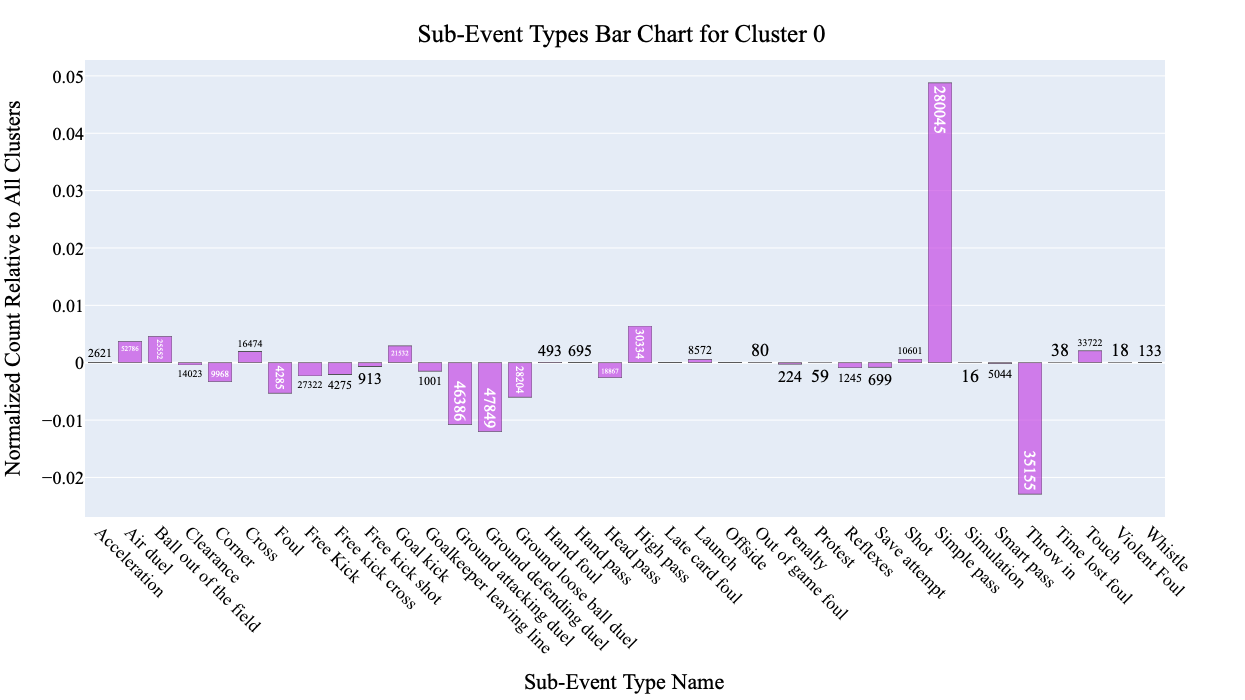

<Figure size 432x288 with 0 Axes>

In [81]:
# first cluster
cluster_0_bar_obj = bv.plotly_bar_chart(
    cluster0_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=0,
    total_count_df=event_types_counts
)
cluster_0_bar_obj.show()
print("", end="\n\n")

cluster_0_sub_bar_obj = bv.plotly_bar_chart(
    cluster0_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=0,
    total_count_df=sub_event_types_counts
)
cluster_0_sub_bar_obj.show()

In [89]:
### Only run if you wish to save the above figures ###
img_rel_path = "../visualizations/initial_clustering/clusters_investigation/kmeans"
img_path = os.path.join(notebook_dir, img_rel_path)

cluster_0_bar_obj.write_image(
    file="{}/event_types_rel_hist_0.png".format(img_path), format="png"
)
cluster_0_sub_bar_obj.write_image(
    file="{}/subevent_types_rel_hist_0.png".format(img_path), format="png"
)

When looking at the sequences that were closest to this cluster's centroid, we concluded that this cluster was made up of set piece sequences that started from set pieces in the attacking team's own half of the field or very near it. This could include events like non-goalie free kicks and throw-ins. 

After takiing a look at these histograms for the cluster, we see that the most prominent non-pass event types are duels and free kicks and that the most prominent non-simple-pass sub-event types are, by a thin margin since this distriubtion is pretty flat, air duels, ground attacking duel, and ground defending duels. This is fairly consistent with our initial conclusion especially considering that the throw in subevent is also fairly prominent and that the non-simple-pass sub-event type distribution should be very flat when the attacking team is simply making passes in their defending third and half leading to not much other kinds of events and sub-events occuring. Thus, we can also characterize this cluster as the "boring" cluster where not much of an attack is occuring after the set piece.

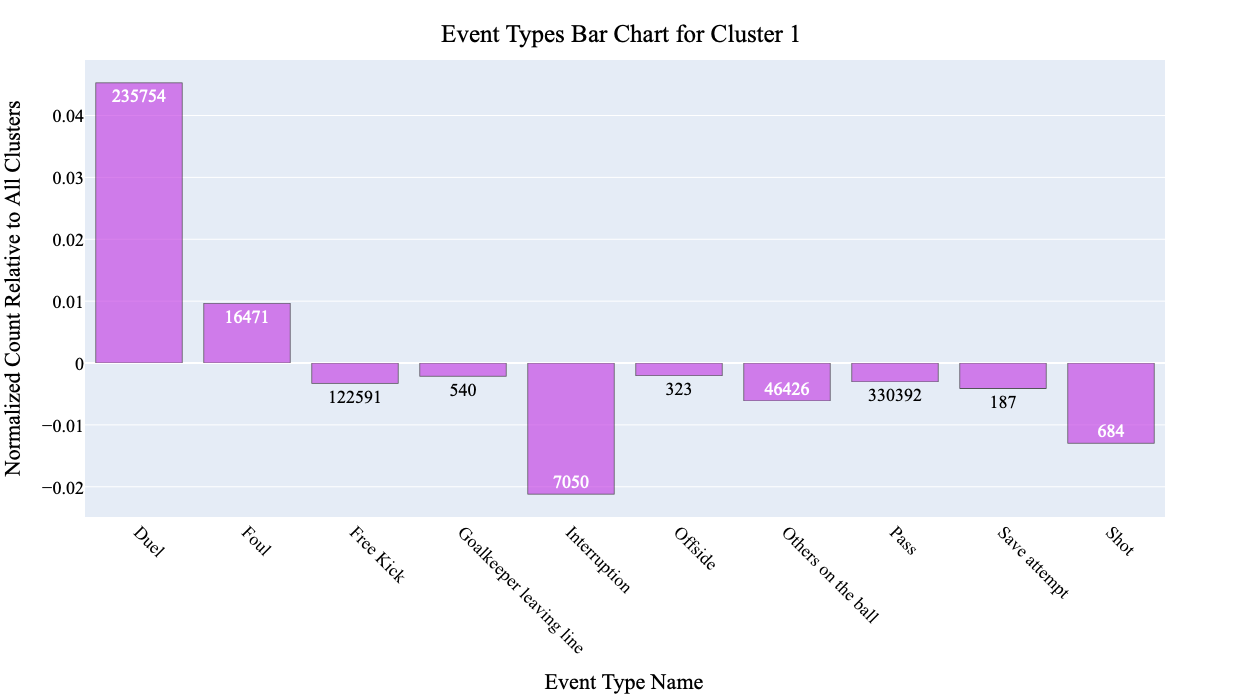

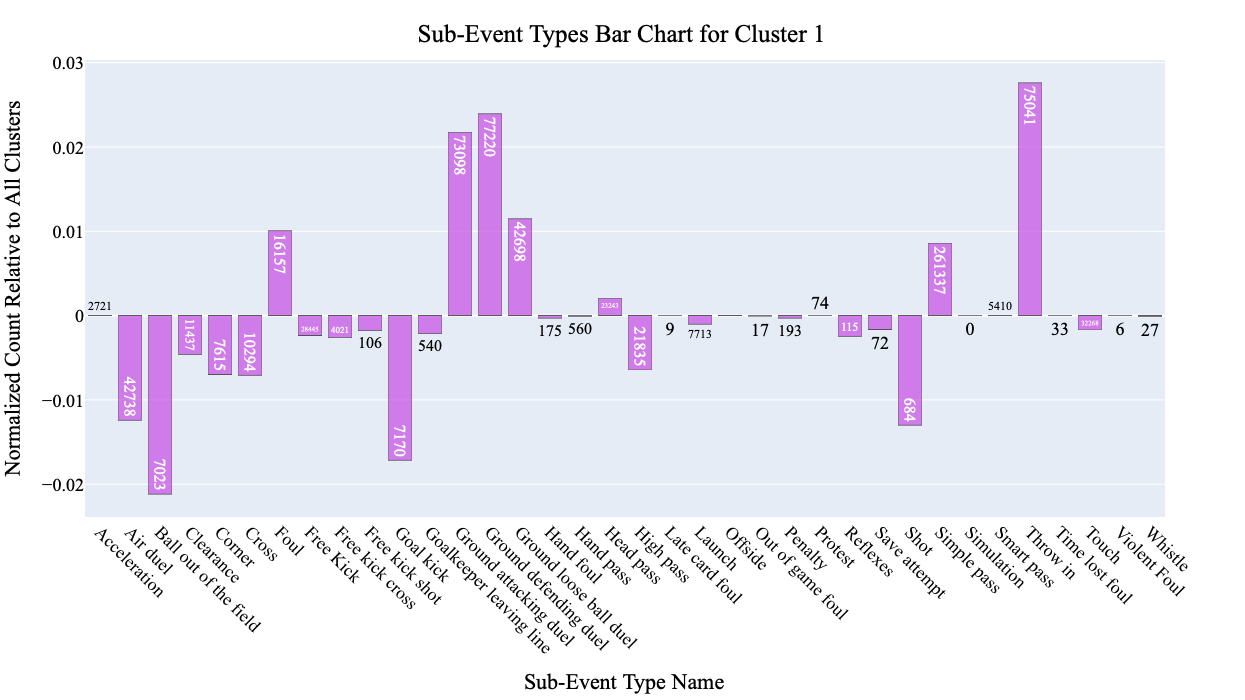

In [82]:
# second cluster
cluster_1_bar_obj = bv.plotly_bar_chart(
    cluster1_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=1,
    total_count_df=event_types_counts
)
cluster_1_bar_obj.show()
print("", end="\n\n")

cluster_1_sub_bar_obj = bv.plotly_bar_chart(
    cluster1_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=1,
    total_count_df=sub_event_types_counts
)
cluster_1_sub_bar_obj.show()

In [90]:
### Only run if you wish to save the above figures ###
img_rel_path = "../visualizations/initial_clustering/clusters_investigation/kmeans"
img_path = os.path.join(notebook_dir, img_rel_path)

cluster_1_bar_obj.write_image(
    file="{}/event_types_rel_hist_1.png".format(img_path), format="png"
)
cluster_1_sub_bar_obj.write_image(
    file="{}/subevent_types_rel_hist_1.png".format(img_path), format="png"
)

When looking at the sequences that were closest to this cluster's centroid, we concluded that this was the "attacking" cluster where most of the events occur in the attacking third of the pitch following set pieces like free kicks and corners. This is the cluster with the highest proportion of duels which would make sense with the ball being in the attacking third where space between players tends to shrink thanks to a small amount of remaining field and defensive strategy.

However, one characteristic we can add to this cluster after looking at these distribution of event and sub-event types is that despite being a generally "attacking" cluster, it is still not as "exciting" as one would inititally think because we see a low proportion of events in which the goalie leaves their line, a cross was made into the box, the defending team had to clear the ball, and (perhaps most importantly) a shot attempt was made. 

Thus, this is perhaps a cluster where many events are made in the attacking half, but the attack ultimately fails with the possession moving over to the other team. Then the low (very negative) value for the closest data point to the cluster centroid for the `to_goal_delta_diff` feature could instead be explained by the defending team sucessfully making passes away from their goal instead of simply clearing the ball. This could be confirmed by taking a look at:
1. The number of times the set piece sequence was deemed to have ended because of either the defending team successfully starting a counter-attack or simply being able to move the ball into the attacking team's half of the field thanks to a series of passes after taking posession. 
2. The number of goals scored in the sequences of this cluster.

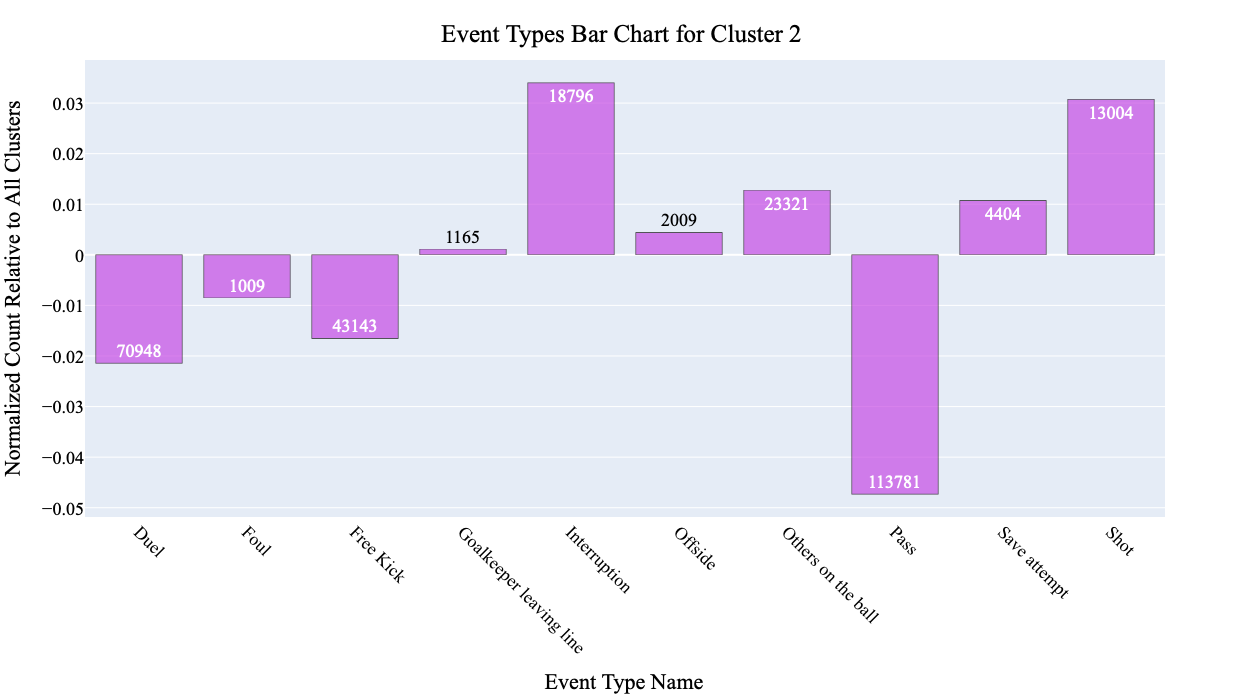

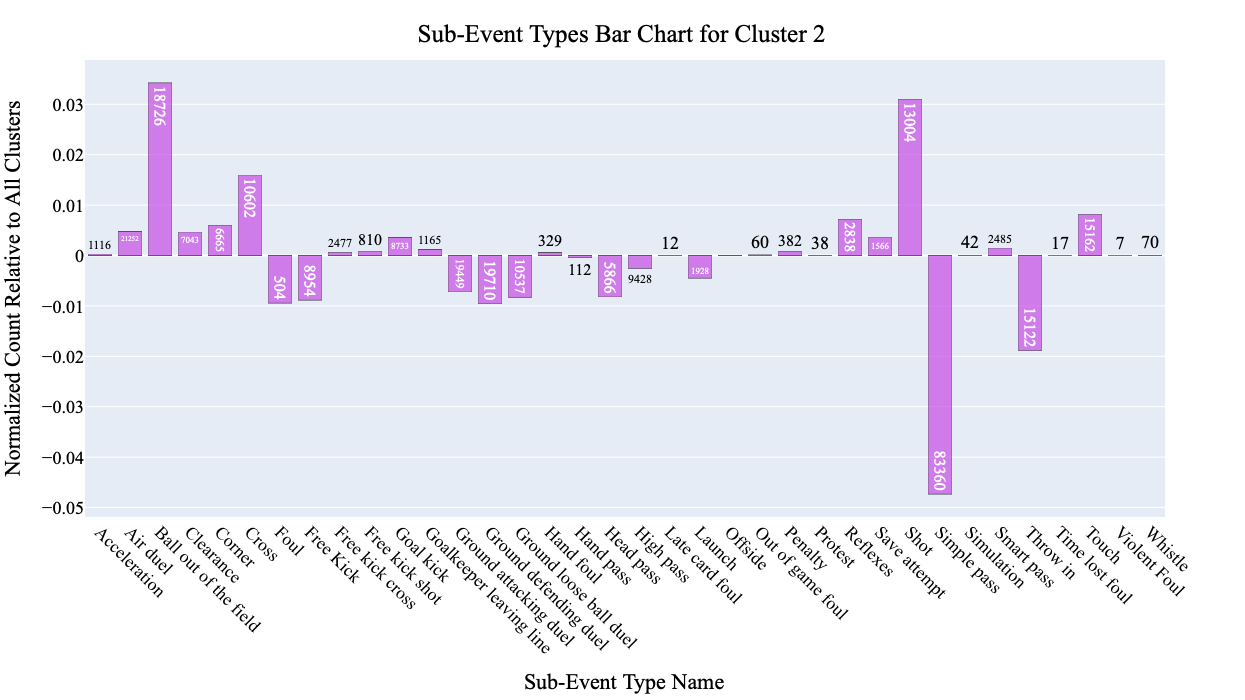

In [83]:
# third cluster
cluster_2_bar_obj = bv.plotly_bar_chart(
    cluster2_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=2,
    total_count_df=event_types_counts
)
cluster_2_bar_obj.show()
print("", end="\n\n")

cluster_2_sub_bar_obj = bv.plotly_bar_chart(
    cluster2_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=2,
    total_count_df=sub_event_types_counts
)
cluster_2_sub_bar_obj.show()

In [91]:
### Only run if you wish to save the above figures ###
img_rel_path = "../visualizations/initial_clustering/clusters_investigation/kmeans"
img_path = os.path.join(notebook_dir, img_rel_path)

cluster_2_bar_obj.write_image(
    file="{}/event_types_rel_hist_2.png".format(img_path), format="png"
)
cluster_2_sub_bar_obj.write_image(
    file="{}/subevent_types_rel_hist_2.png".format(img_path), format="png"
)

When looking at the sequences that were closest to this cluster's centroid, we concluded that

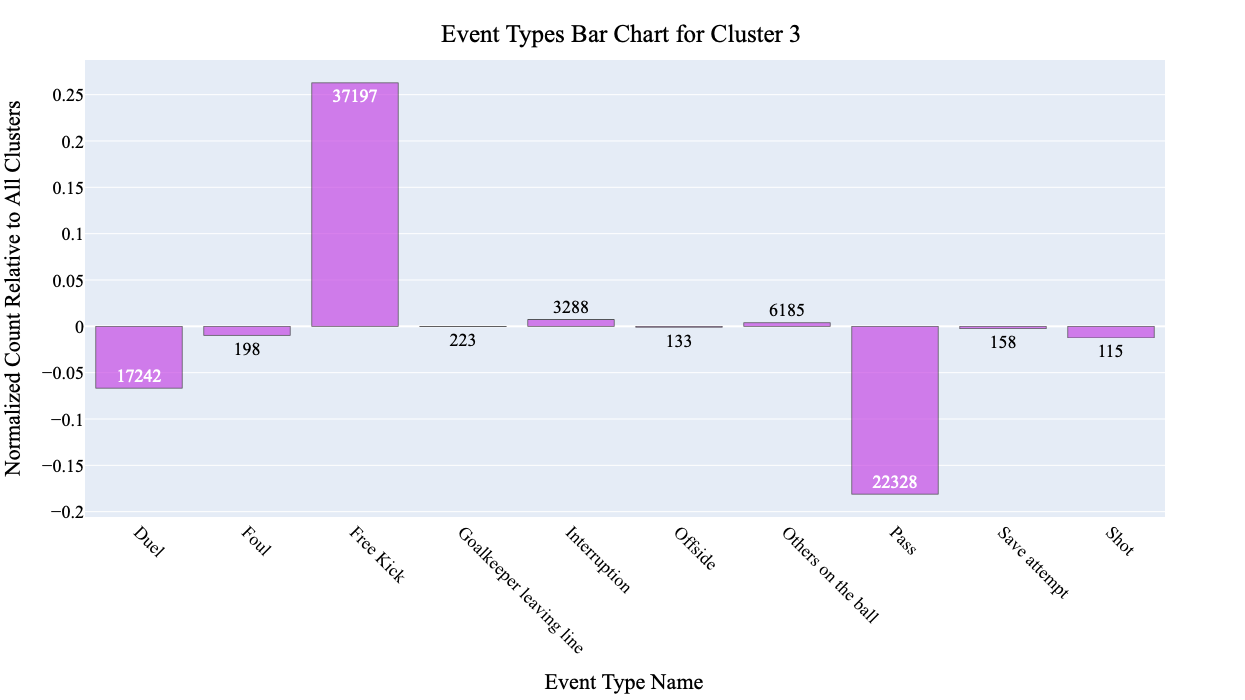

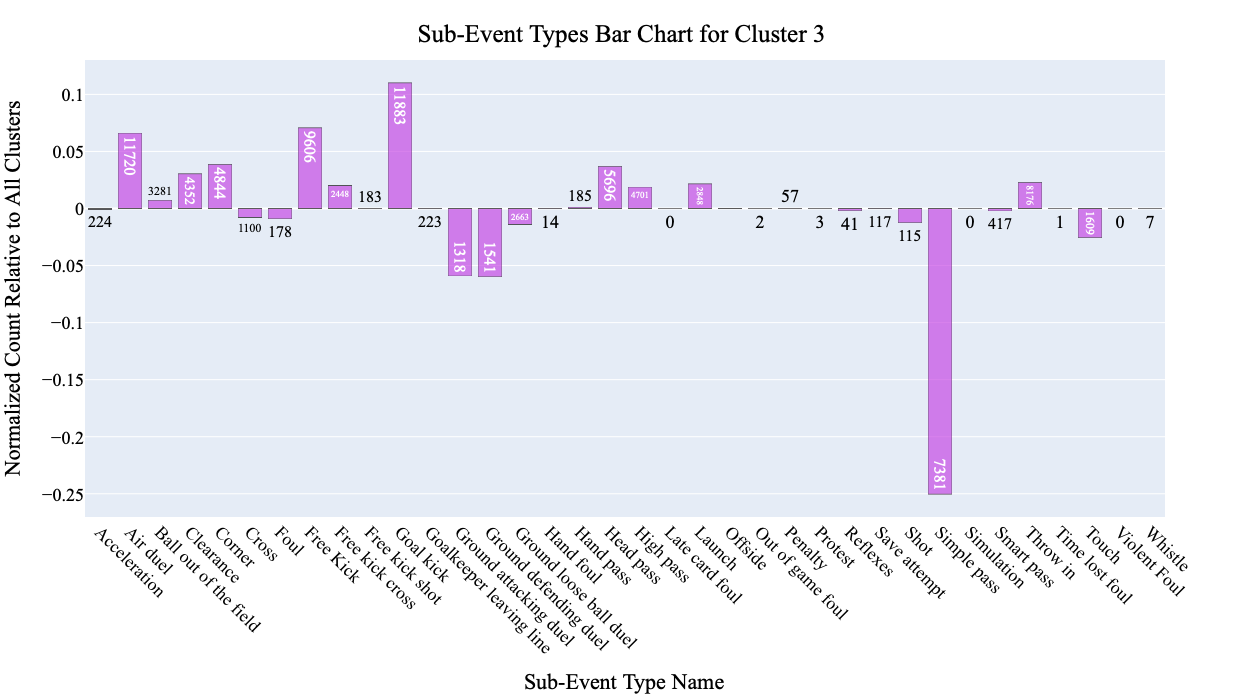

In [84]:
# fourth cluster
cluster_3_bar_obj = bv.plotly_bar_chart(
    cluster3_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=3,
    total_count_df=event_types_counts
)
cluster_3_bar_obj.show()
print("", end="\n\n")

cluster_3_sub_bar_obj = bv.plotly_bar_chart(
    cluster3_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=3,
    total_count_df=sub_event_types_counts
)
cluster_3_sub_bar_obj.show()

In [92]:
### Only run if you wish to save the above figures ###
img_rel_path = "../visualizations/initial_clustering/clusters_investigation/kmeans"
img_path = os.path.join(notebook_dir, img_rel_path)

cluster_3_bar_obj.write_image(
    file="{}/event_types_rel_hist_3.png".format(img_path), format="png"
)
cluster_3_sub_bar_obj.write_image(
    file="{}/subevent_types_rel_hist_3.png".format(img_path), format="png"
)

When looking at the sequences that were closest to this cluster's centroid, we concluded that this was a fairly conservative cluster with a lot of passes being made by the attacking team in their own third and half of the pitch. This is supported by the fact that this cluster has the highest proportion of goalie-kicks which would make sense given that when the attacking team is initiating events in this part of the field, they are more likely to play out from their own goal. We also see a very high number of air duels in this cluster which almost always follow goalie kicks. Additionally, air duels are normally won by whoever is able to head the ball to their own team which would explain the high number of head passes.

This cluster also has quite a proportion of throw-ins. Thus, if we would like to generally characterize this cluster, we could go with saying that cluster is made of set piece sequence that are played from the back of the attacking team's field. This would certainly explain the high values for the indicator variables for goalie, defender, and midfielder and the very low value for the forward indicator variable.

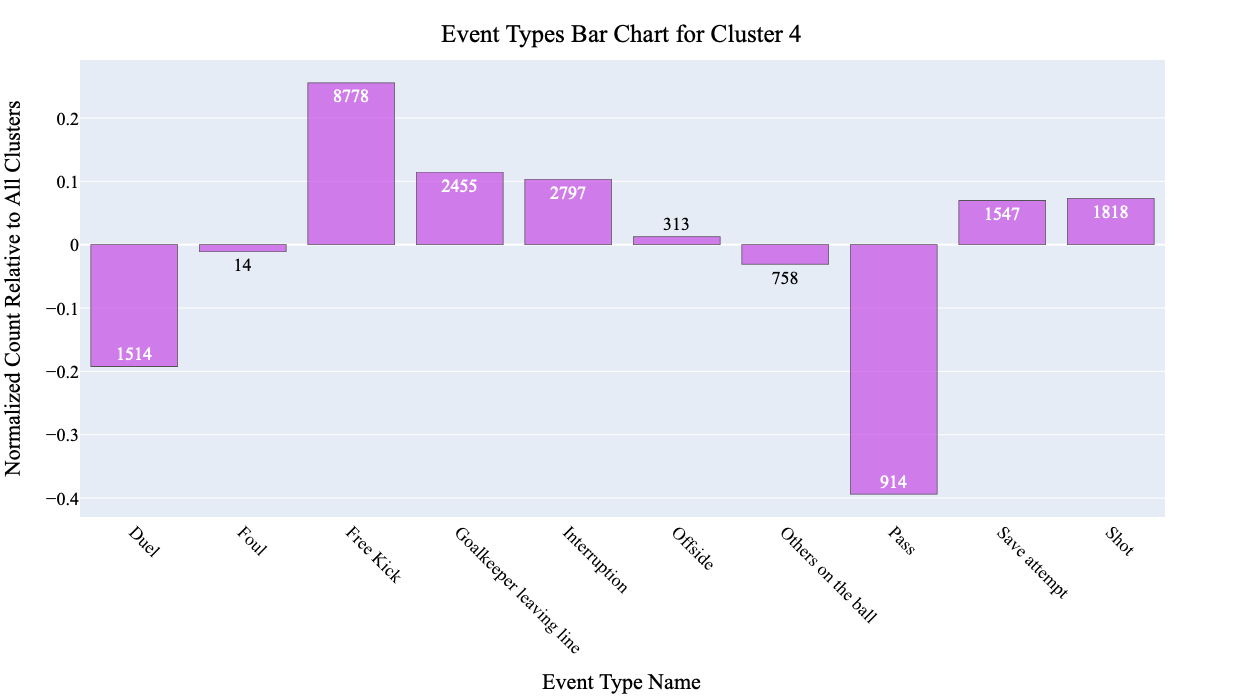

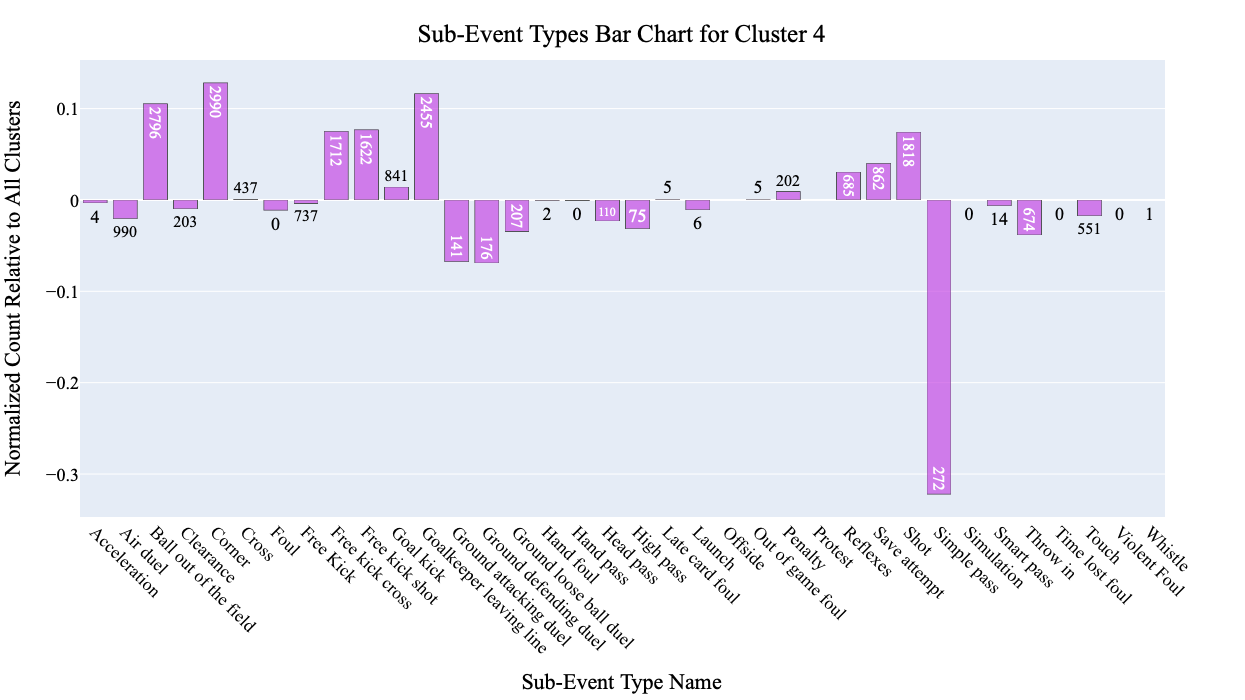

In [85]:
# fifth cluster
cluster_4_bar_obj = bv.plotly_bar_chart(
    cluster4_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=4,
    total_count_df=event_types_counts
)
cluster_4_bar_obj.show()
print("", end="\n\n")

cluster_4_sub_bar_obj = bv.plotly_bar_chart(
    cluster4_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=4,
    total_count_df=sub_event_types_counts
)
cluster_4_sub_bar_obj.show()

In [93]:
### Only run if you wish to save the above figures ###
img_rel_path = "../visualizations/initial_clustering/clusters_investigation/kmeans"
img_path = os.path.join(notebook_dir, img_rel_path)

cluster_4_bar_obj.write_image(
    file="{}/event_types_rel_hist_4.png".format(img_path), format="png"
)
cluster_4_sub_bar_obj.write_image(
    file="{}/subevent_types_rel_hist_4.png".format(img_path), format="png"
)

When looking at the sequences that were closest to this cluster's centroid, we concluded that this cluster was the primary home for goalie kicks. Testing this conclusion with the information gleaned from the cluster's event and sub-event histograms, we do find support in the fact that this cluster is essentially tied for the highest proportion of free kicks across the clusters.

However, this cluster also has the highest proportion of shots, corners, and save attempts. This information would make one conclude that instead this cluster is a collection of set piece sequences that occur in the attacking third of the pitch and were ended by a shot attempt being saved by a goalie. The high value for the delta position feature could be because after the save by the defending team's goalie, they performed a goal kick towards the attacking team's goal. We could confirm this by:
1. Determining the number of sequences in this cluster that ended with either the ball being out of play behind the goal, the defending team's goalie making a save, or with possession changing teams and the defending team then starting their new position with a goalie-kick.
2. The proportion of goalie-kicks made by the attacking team v. that made by the defending team.